In [1]:
using Pkg
Pkg.activate("..")
Pkg.instantiate()

  Activating project at `~/Projects/bind_RBM`


In [2]:
using CairoMakie
using RestrictedBoltzmannMachines: sample_from_inputs, inputs_h_from_v, mean_from_inputs
using DelimitedFiles, LinearAlgebra, Statistics, Random
using RestrictedBoltzmannMachines: RBM, Potts, Binary, ReLU, nsReLU, log_pseudolikelihood, initialize!, pcd!,
             sample_v_from_v, free_energy, onehot_encode, sample_h_from_v
using Statistics: mean, cov, std, var, cor
using LinearAlgebra: norm
const ALPHABET = "ACDEFGHIKLMNPQRSTVWY-"
alphabet_dict = Dict(c => i for (i, c) in enumerate(ALPHABET))
split_idx = 81
using JLD2
using MultivariateStats
using MLJ, MLJLinearModels
using Random: MersenneTwister, shuffle, bitrand
using DataFrames
using Logging
using SequenceLogos
using XLSX
alphabet = collect("ACDEFGHIKLMNPQRSTVWY-")
using bind_RBM: plot_model_vs_data
split_lookup = Dict(
    "Binary_f_fs_7.jld2"        =>7,
    "Binary_f_fs_5.jld2"        =>5,
    "Binary_f_fs_10.jld2"        =>10,
    "Binary_f_fs_15.jld2"        =>15,
    "Binary_fs_20.jld2"        =>20,
    "Binary_fs_5.jld2"        =>5,
    "Binary_fs_10.jld2"        =>10,
    "Binary_fs_15.jld2"        =>15,
    "Binary_fs_20_correct.jld2"        =>20,
    "Binary_fs_5_correct.jld2"        =>5,
    "Binary_fs_10_correct.jld2"        =>10,
    "Binary_fs_15_correct.jld2"        =>15  
)

Dict{String, Int64} with 12 entries:
  "Binary_fs_5.jld2"          => 5
  "Binary_fs_10_correct.jld2" => 10
  "Binary_fs_15_correct.jld2" => 15
  "Binary_f_fs_5.jld2"        => 5
  "Binary_fs_20_correct.jld2" => 20
  "Binary_fs_15.jld2"         => 15
  "Binary_fs_5_correct.jld2"  => 5
  "Binary_f_fs_7.jld2"        => 7
  "Binary_f_fs_15.jld2"       => 15
  "Binary_f_fs_10.jld2"       => 10
  "Binary_fs_20.jld2"         => 20
  "Binary_fs_10.jld2"         => 10

In [3]:
function onehot_from_file(filepath::String, alphabet::Vector{Char})
    # Read sequences from file
    raw_sequences = filter(!isempty, strip.(readlines(filepath)))
    # Build lookup table
    aa_to_index = Dict(aa => i for (i, aa) in enumerate(alphabet))

    # Filter sequences with invalid characters
    valid_sequences = []
    invalid_count = 0

    for seq in raw_sequences
        if all(aa -> aa in keys(aa_to_index), seq)
            push!(valid_sequences, seq)
        else
            invalid_count += 1
        end
    end
    # Ensure all valid sequences are same length
    seq_length = length(valid_sequences[1])
    if !all(length.(valid_sequences) .== seq_length)
        error("❌ Not all valid sequences have equal length!")
    end

    # Allocate one-hot tensor
    A = length(alphabet)
    L = seq_length
    N = length(valid_sequences)
    onehot = zeros(Float32, A, L, N)

    # Fill one-hot tensor
    for (n, seq) in enumerate(valid_sequences)
        for (pos, aa) in enumerate(seq)
            onehot[aa_to_index[aa], pos, n] = 1
        end
    end

    return onehot
end

function read_protein_onehot_file(path::String)
    alphabet_size  = 21
    protein_length = 81
    proteins = Matrix{Bool}[]

    for raw in eachline(path)
        clean = strip(raw, ['[',']'])       # remove brackets only
        blocks = split(clean, ";")          # 21 rows

        @assert length(blocks) == alphabet_size "Expected 21 rows, got $(length(blocks))"

        mat = Matrix{Bool}(undef, alphabet_size, protein_length)

        for (i, row) in enumerate(blocks)
            nums = split(strip(row))  # split on spaces
            @assert length(nums) == protein_length "Row $i has $(length(nums)) cols, expected $protein_length"

            # Convert "1.0"/"0.0" to Bool
            mat[i, :] .= nums .== "1.0"
        end

        push!(proteins, mat)
    end

    # Stack into 3D array (21 × 81 × N)
    N = length(proteins)
    result = falses(alphabet_size, protein_length, N)
    for i in 1:N
        result[:, :, i] .= proteins[i]
    end

    return result
end

read_protein_onehot_file (generic function with 1 method)

In [4]:
data_training = onehot_from_file("/home/jboccato/Projects/bind_RBM/artifacts/data/first_5000_sequences.txt", alphabet)

21×81×4992 Array{Float32, 3}:
[:, :, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  1.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0

In [5]:
using DelimitedFiles  # for readdlm
using bind_RBM: plot_model_vs_data

function plot_rbms_convergence(
    rbm_dir::String,
    v_dir::String,
    X::Array{<:Real,3};
    rbm_ext=".jld2",
    v_suffix="_sampled.txt")

    rbm_files = sort(filter(f -> endswith(f, rbm_ext), readdir(rbm_dir)))
    println("🎯 Found $(length(rbm_files)) RBMs to plot")

    results = NamedTuple[]

    for file in rbm_files
        println("📌 RBM: $file")
        rbm_path = joinpath(rbm_dir, file)

        # Construct sampled visible filename
        v_file = replace(file, rbm_ext => v_suffix)
        v_path = joinpath(v_dir, v_file)

        if !isfile(v_path)
            @warn "⚠️ Missing sampled visible: $v_file — skipping"
            continue
        end

        try
            rbm = load_object(rbm_path)
            sampled_v = read_protein_onehot_file(v_path)
            
            if isempty(sampled_v) || ndims(sampled_v) != 3
                error("❌ Loaded invalid sampled_v: $(size(sampled_v)) from $v_file")
            end

            # Plot
            fig = plot_model_vs_data(X, sampled_v, rbm)

            # Save figure
            out_png = joinpath(
                v_dir,
                replace(file, rbm_ext => "_vis_vs_data.png")
            )
            save(out_png, fig)
            println("   📈 Saved plot: $out_png")

            push!(results, (rbm = file, plot = out_png))

        catch e
            @warn "❌ Failed on $file — $e"
        end
    end

    return results
end

plot_rbms_convergence (generic function with 1 method)

In [9]:
plot_rbms_convergence(
    "/home/jboccato/Projects/bind_RBM/artifacts/rbms_ReLU",
    "/home/jboccato/Projects/bind_RBM/artifacts/sampled_output",
    data_training
    )

LoadError: UndefVarError: `plot_rbms_convergence` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/Vn16E/src/scenes.jl:264


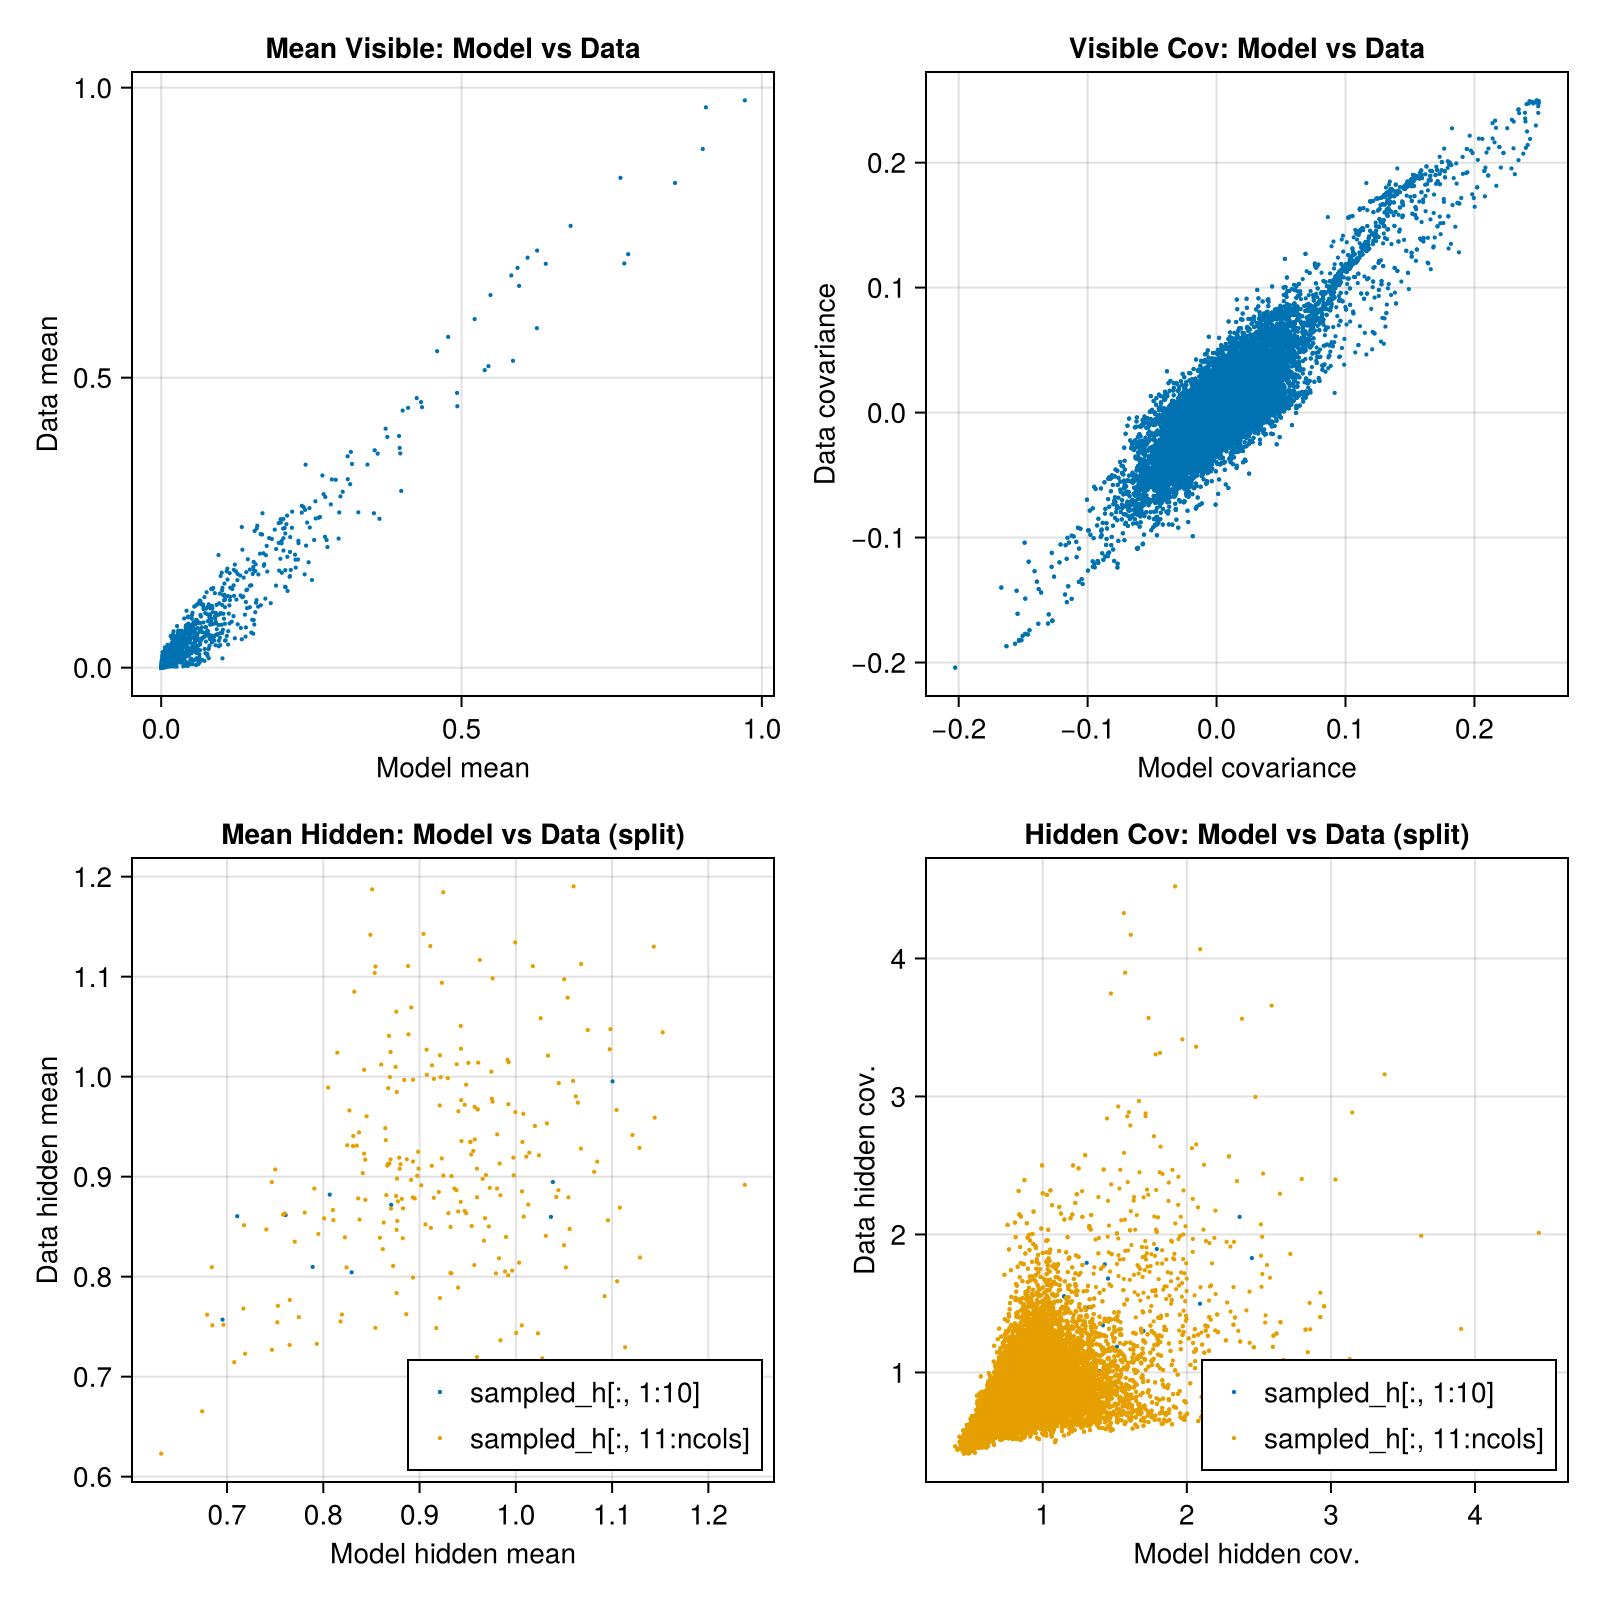

In [6]:
using bind_RBM: plot_model_vs_data

rbm = load_object("/home/jboccato/Projects/bind_RBM/artifacts/rbms_ReLU/ReLU_f_fs_10.jld2")
sampled_v = read_protein_onehot_file("/home/jboccato/Projects/bind_RBM/artifacts/sampled_output/ReLU_f_fs_10_sampled.txt")

plot_model_vs_data(data_training, sampled_v, rbm, 10)

In [6]:
function filter_lookup_concat(main_file::String, lookup_file::String, threshold::Real)
    filter_col = "DAPF_neglogKd"

    main_df = DataFrame(XLSX.readtable(main_file, 2))
    mask    = coalesce.(main_df[!, filter_col] .> threshold, false)
    classes = Int.(mask)

    ids    = main_df[!, 1]
    aa_str = main_df[!, 4]

    lookup_dict = Dict{String, String}()
    lookup_df   = DataFrame(XLSX.readtable(lookup_file, 1))

    for row in eachrow(lookup_df)
        if !ismissing(row[1]) && !ismissing(row[3])
            lookup_dict[strip(string(row[1]))] = strip(string(row[3]))
        end
    end

    result  = String[]
    out_cls = Int[]
    skipped = 0

    for i in 1:nrow(main_df)
        id = ids[i]
        aa = aa_str[i]

        if ismissing(id) || ismissing(aa)
            skipped += 1
            continue
        end

        sid = strip(string(id))
        lookup_value = get(lookup_dict, sid, nothing)

        if lookup_value === nothing
            skipped += 1
            continue
        end

        push!(result, lookup_value * string(aa))
        push!(out_cls, classes[i])
    end

    println("Skipped rows: $skipped")

    return result, out_cls
end
function read_binding_file(filepath::String)
    open(filepath, "r") do io
        col2, col4, col5_binary = String[], String[], Int[]
        for line in eachline(io)
            isempty(strip(line)) && continue
            parts = split(line, '\t')
            length(parts) < 5 && continue
            push!(col2, parts[2]); push!(col4, parts[4])
            push!(col5_binary, lowercase(strip(parts[5])) == "yes" ? 1 : 0)
        end
        return col2, col4, col5_binary
    end
end

function one_hot_encode(sequences::Vector{String}, alphabet::Vector{Char}, aa_to_index::Dict{Char, Int})
    N = length(sequences)
    L = length(sequences[1])
    A = length(alphabet)
    @assert all(length(seq) == L for seq in sequences) "Sequences must be of equal length"
    one_hot = zeros(Float32, A, L, N)
    for (seq_idx, seq) in enumerate(sequences)
        for (pos, aa) in enumerate(seq)
            idx = aa_to_index[aa]
            one_hot[idx, pos, seq_idx] = 1.0f0
        end
    end
    return one_hot
end
function Q_inter_centered(
    filtered_tensor::AbstractArray{T,3},
    split_idx::Int,
    labels::AbstractVector{<:Real}
) where {T<:Real}

    a, n_amino, n_exp = size(filtered_tensor)
    @assert 1 ≤ split_idx < n_amino
    @assert length(labels) == n_exp

    # reshape tensor
    U = reshape(filtered_tensor[:, 1:split_idx, :],
                a * split_idx, n_exp)
    V = reshape(filtered_tensor[:, split_idx+1:end, :],
                a * (n_amino - split_idx), n_exp)

    # center data
    μU = mean(U, dims=2)
    μV = mean(V, dims=2)
    Uc = U .- μU
    Vc = V .- μV

    # accumulate label-weighted interactions
    acc = zeros(Float32, size(U,1), size(V,1))
    y = Float32.(labels)

    for i in 1:n_exp
        acc .+= y[i] .* (Uc[:, i] * Vc[:, i]')
    end

    return acc ./ n_exp
end

Q_inter_centered (generic function with 1 method)

In [10]:
using JLD2
using XLSX
pdz_pep_data = JLD2.load("/home/jboccato/Projects/bind_RBM/artifacts/data/labelled/pdz_pep_matrices_fast.jld2")

V_matrix = pdz_pep_data["V_general"]  # Peptide embedding matrix
U_matrix = pdz_pep_data["U_general"]  # PDZ embedding matrix


filename_1 = "/home/jboccato/Projects/bind_RBM/artifacts/data/labelled/output.txt"
Gogl_seq, classes = filter_lookup_concat("/home/jboccato/Projects/bind_RBM/artifacts/data/labelled/PDZ_2022.xlsx", "/home/jboccato/Projects/bind_RBM/artifacts/data/labelled/PDZ_2022_final.xlsx", 4)

receptor_str, ligand_str, bind_vec = read_binding_file(filename_1)
label_Stiffler = receptor_str .* ligand_str

Stiffler_onehot = one_hot_encode(label_Stiffler, alphabet, alphabet_dict)
Gogl_onehot = one_hot_encode(Gogl_seq, alphabet, alphabet_dict)


labels = cat(classes, bind_vec, dims=1)
onehot = cat(Gogl_onehot, Stiffler_onehot, dims=3)

labeled_reshape = reshape(onehot, :, size(onehot, 3))

onehot_seq = onehot[:, 1:split_idx, :]
onehot_pep = onehot[:, split_idx+1:end, :]
Q_interaction_centered = Q_inter_centered(onehot, split_idx, labels)
n_singular_vectors = size(V_matrix, 2)
M = Q_interaction_centered * V_matrix
print(size(M))


Skipped rows: 2037
(1701, 5)

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/Vn16E/src/scenes.jl:264


Most frequent pattern for label 0: 658 (count = 1977)
Most frequent pattern for label 1: 481 (count = 418)


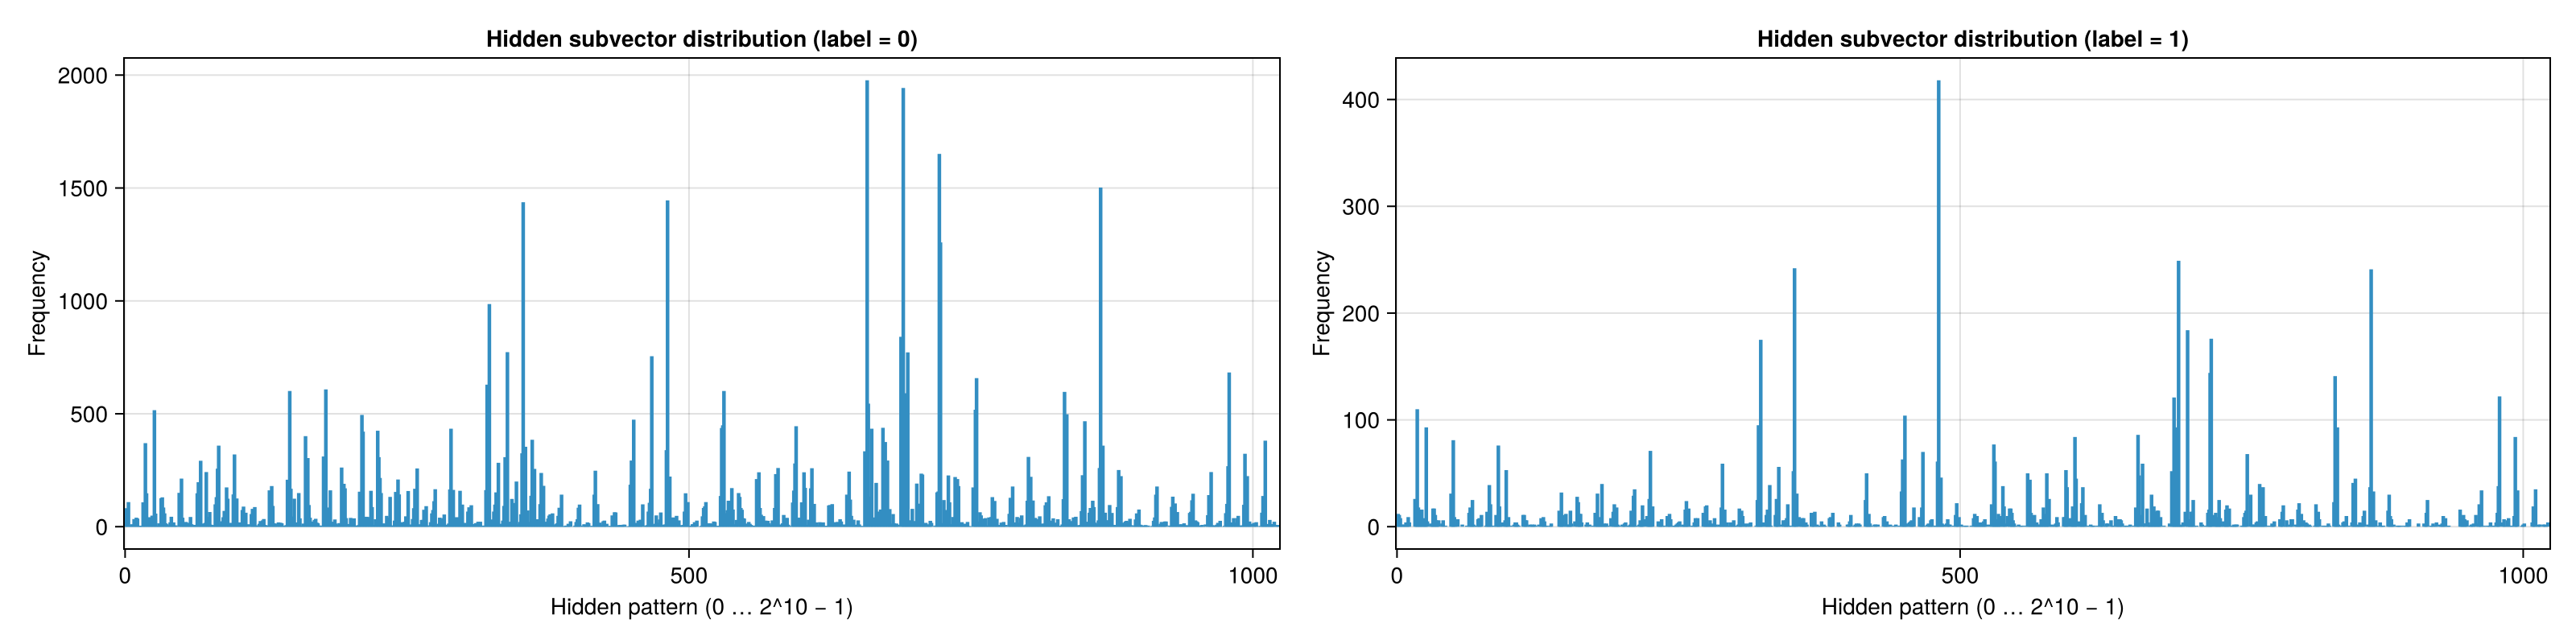

In [40]:
rbm = load_object("/home/jboccato/Projects/bind_RBM/artifacts/rbms_f_fs//Binary_f_fs_10.jld2")
subset = 1:10


function plot_hidden_pattern_distribution_labelled(data, labels, rbm, subset)
    @assert size(data, 3) == length(labels) "Number of samples and labels must match"

    h_samples = sample_h_from_v(rbm, data)

    nbits = length(subset)
    npatterns = 2^nbits

    counts0 = zeros(Int, npatterns)  # label == 0
    counts1 = zeros(Int, npatterns)  # label == 1

    @inbounds for i in 1:size(h_samples, 2)
        idx = 0
        for (k, j) in enumerate(subset)
            idx |= (Int(h_samples[j, i]) << (k - 1))
        end

        if labels[i] == 0
            counts0[idx + 1] += 1
        elseif labels[i] == 1
            counts1[idx + 1] += 1
        else
            error("Labels must be binary (0 or 1)")
        end
    end

    # ---- PLOT ----
    fig = CairoMakie.Figure(resolution = (1600, 400))

    ax0 = Axis(
        fig[1, 1],
        xlabel = "Hidden pattern (0 … 2^$nbits − 1)",
        ylabel = "Frequency",
        title = "Hidden subvector distribution (label = 0)"
    )

    ax1 = Axis(
        fig[1, 2],
        xlabel = "Hidden pattern (0 … 2^$nbits − 1)",
        ylabel = "Frequency",
        title = "Hidden subvector distribution (label = 1)"
    )

    barplot!(ax0, 0:npatterns-1, counts0; width = 4.0)
    barplot!(ax1, 0:npatterns-1, counts1; width = 4.0)

    xlims!(ax0, -1, npatterns)
    xlims!(ax1, -1, npatterns)

    fig, counts0, counts1
end
fig, counts0, counts1 = plot_hidden_pattern_distribution_labelled(onehot_seq, labels, rbm, subset)

idx0 = argmax(counts0)
idx1 = argmax(counts1)

pattern0 = idx0 - 1
pattern1 = idx1 - 1

println("Most frequent pattern for label 0: ", pattern0,
        " (count = ", counts0[idx0], ")")

println("Most frequent pattern for label 1: ", pattern1,
        " (count = ", counts1[idx1], ")")

fig

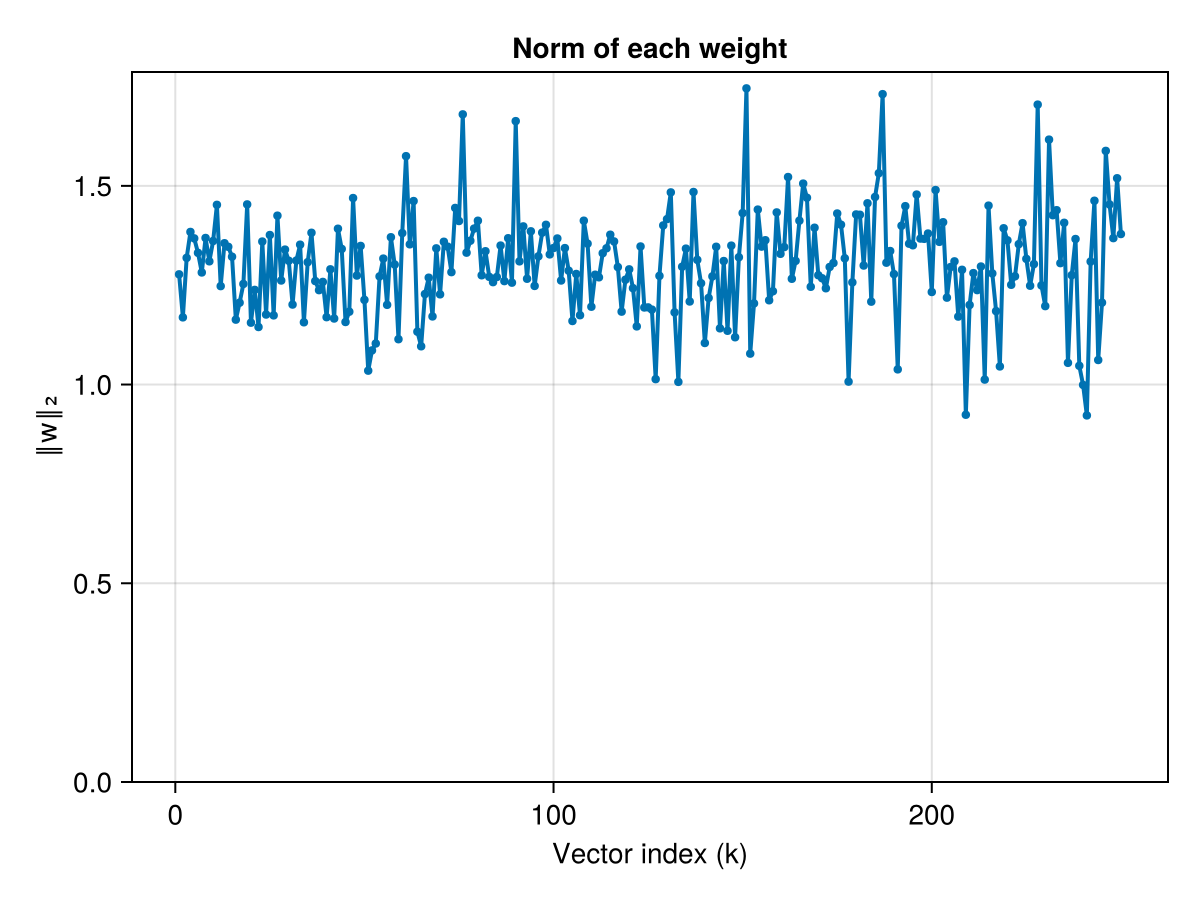

In [3]:
function plot_slice_norms(A)
    @assert ndims(A) == 3 "Input must be a 3D array"

    norms = [norm(vec(A[:, :, k])) for k in 1:size(A, 3)]

    # Check for very small norms
    threshold = 1e-8
    small_indices = findall(<(threshold), norms)
    if !isempty(small_indices)
        println("⚠️ Warning: Norms below $threshold detected at indices: $(small_indices)")
    end

    fig = Figure()
    ax = Axis(
        fig[1,1],
        xlabel = "Vector index (k)",
        ylabel = "‖w‖₂",
        title = "Norm of each weight",
        limits = (nothing, nothing, 0, nothing)  # <-- Set y-axis to start at 0
    )

    lines!(ax, 1:length(norms), norms, linewidth=2)
    scatter!(ax, 1:length(norms), norms, markersize=6)

    return fig
end

rbm = load_object("/home/jboccato/Projects/bind_RBM/artifacts/rbms_ReLU/ReLU_f_fs_15.jld2")
plot_slice_norms(rbm.w)

In [ ]:
rbm = load_object("/home/jacopo/PDZ/rbms_fs_correct/Binary_fs_10_correct.jld2")

plot_matrix_logo(rbm.w[:, :, 1], alphabet; figsize=(12,4), colorscheme=:aminoacid)


: 

In [12]:
using Optim
A2 = reshape(onehot, :, size(onehot,3))
peptide = A2[1702:end, :]
X = Float32.(peptide)      
y = vec(Float32.(labels))

σ(z) = 1 ./ (1 .+ exp.(-z))

function neg_loglik(w, X, y)
    z = vec(w' * X)          # (N,)
    p = σ(z)
    -mean(y .* log.(p) .+ (1 .- y) .* log.(1 .- p))
end

function neg_loglik_grad!(G, w, X, y)
    z = vec(w' * X)          # (N,)
    p = σ(z)
    G[:] = X * (p - y) / length(y)   # (210,)
end

w0 = 0.01 .* randn(210)

res = optimize(
    w -> neg_loglik(w, X, y),
    (G, w) -> neg_loglik_grad!(G, w, X, y),
    w0,
    BFGS()
)

ŵ = Optim.minimizer(res)
a, n_amino, n_exp = size(onehot)
length_alphabet = 21
U = reshape(onehot[:, 1:split_idx, :], length_alphabet  * split_idx, n_exp)
V = reshape(onehot[:, split_idx+1:end, :], length_alphabet  * (n_amino - split_idx), n_exp)  

function compute_vector(U, V, w, y)
    lung, N = size(U)
    @assert size(V, 2) == N           "sanity check 1"
    @assert length(y) == N            "sanity check 2"
    @assert size(w, 2) == size(V, 1)  "sanity check 3"
    @assert size(w, 1) == 1           "sanity check 4"

    # logits: z = w * V   (1×N)
    z = w * V
    @assert size(z) == (1, N)

    # p = σ(z) = 1/(1+exp(-z))  -> vector length N
    p = vec(1 ./(1 .+ exp.(-z)))
    @assert length(p) == N
    return U * (p .- y) / N
end


firstorder_constraint = compute_vector(U, V, ŵ', labels)

1701-element Vector{Float64}:
  0.0
  0.0
  0.0
 -0.0003188075587644623
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  ⋮
  0.0005526638839440481
 -0.00026997031367059326
  0.0
  0.0
 -0.0004993225387599984
  0.0016345674347500376
  0.0
  0.0
  0.0
  0.0
  0.0
 -0.0032894857471293076

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/Vn16E/src/scenes.jl:264


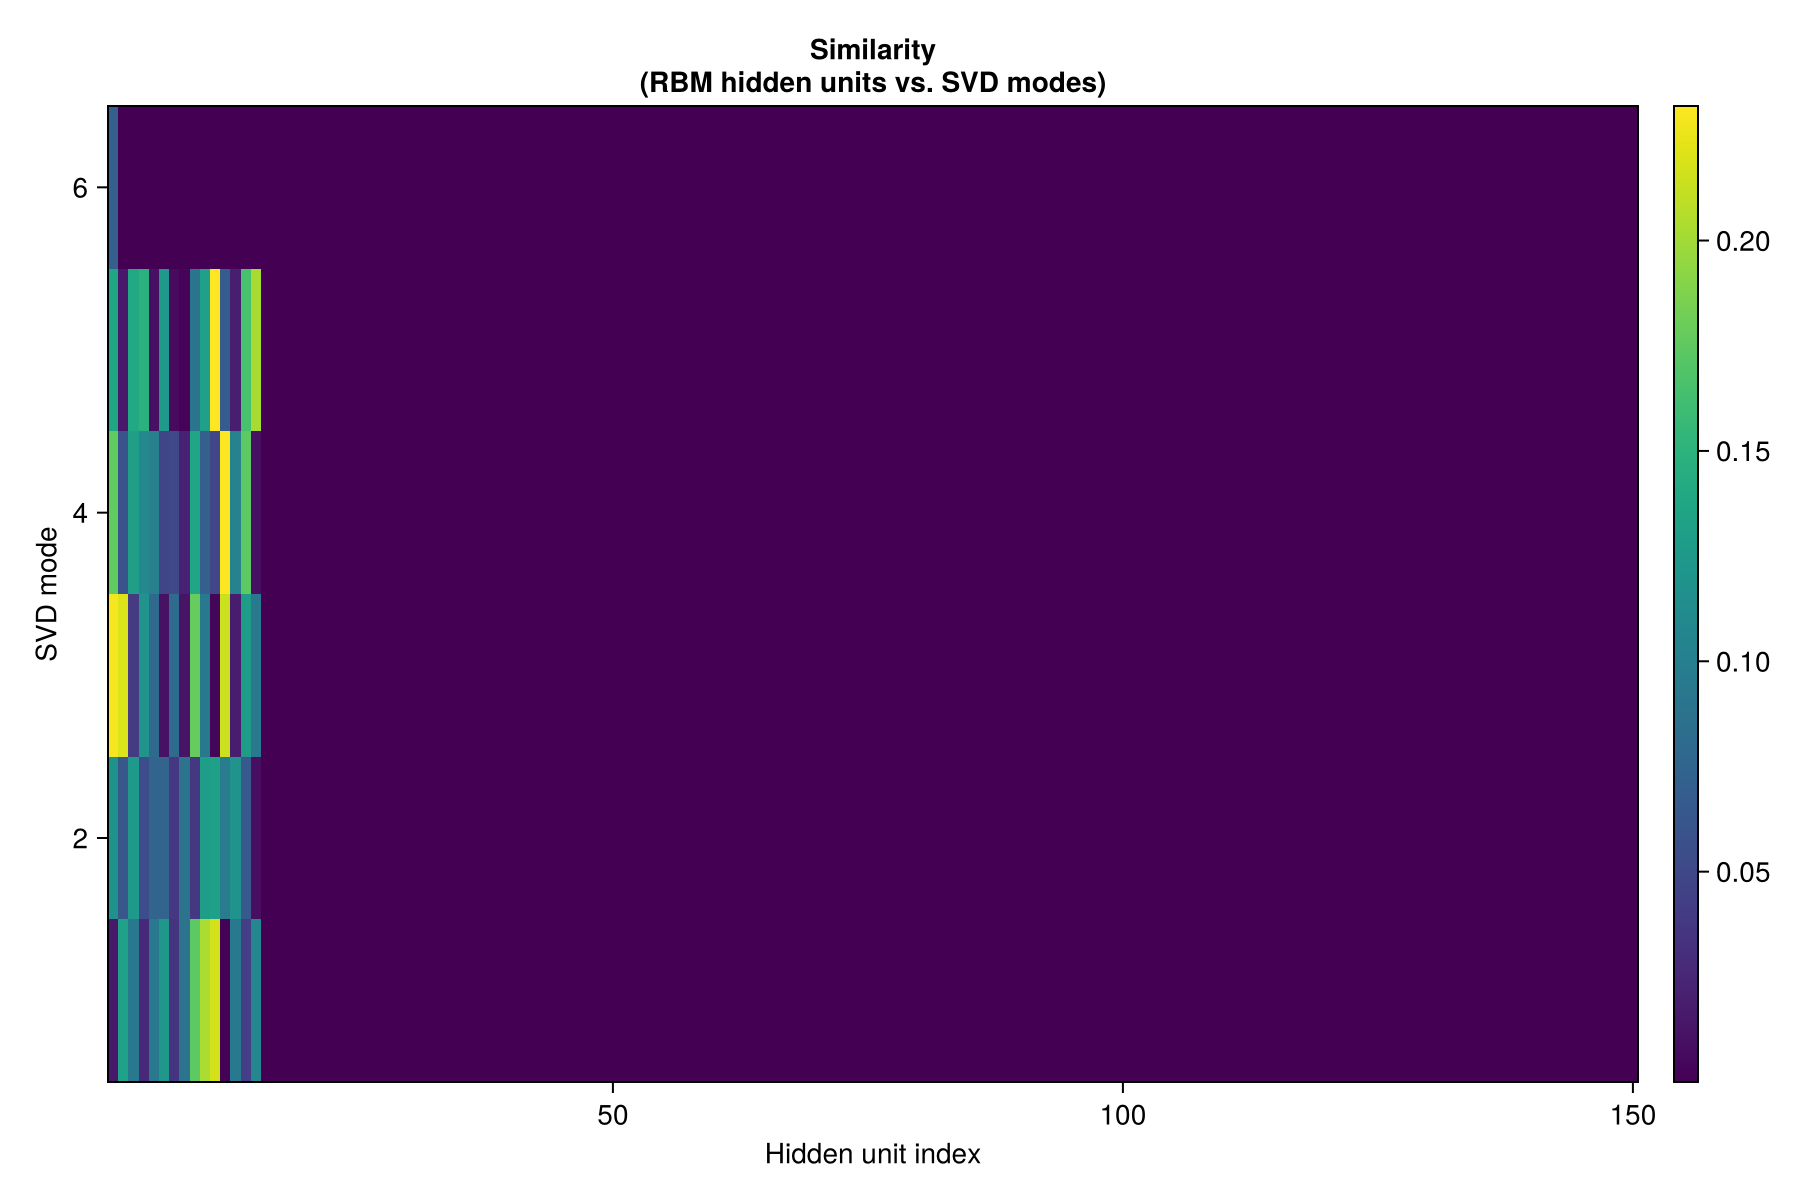

In [13]:
# Ranges you want to test
hidden_range = 1:150
rbm = load_object("/home/jboccato/Projects/bind_RBM/artifacts/rbms_ReLU/ReLU_f_fs_15.jld2")
# Preallocate matrix
sim_matrix = zeros(length(hidden_range), 6)
constraint = reshape(firstorder_constraint, length_alphabet  * split_idx, 1)
M_tot = hcat(M, constraint)

for (row, i) in enumerate(hidden_range)
    u = vec(rbm.w[:, :, i])   # flatten RBM weight tensor for hidden unit i
    unrm = norm(u)
    for (col, j) in enumerate(1:6)
        v = vec(M_tot[:,j]) 
        vnrm = norm(v)
        
        sim_matrix[row, col] = abs(dot(u, v)) / (unrm * vnrm)
    end
end

# ---- Plotting ---- #

fig = CairoMakie.Figure(resolution=(900,600))
ax = Axis(fig[1,1],
    title = "Similarity\n(RBM hidden units vs. SVD modes)",
    xlabel = "Hidden unit index",
    ylabel = "SVD mode"
)

hm = heatmap!(ax, sim_matrix, colormap=:viridis)
Colorbar(fig[1,2], hm)

fig

In [ ]:
function filter_lookup_concat(main_file::String, lookup_file::String, threshold::Real)
    filter_col = "DAPF_neglogKd"

    main_df = DataFrame(XLSX.readtable(main_file, 2))
    mask    = coalesce.(main_df[!, filter_col] .> threshold, false)
    classes = Int.(mask)

    ids    = main_df[!, 1]
    aa_str = main_df[!, 4]

    lookup_dict = Dict{String, String}()
    lookup_df   = DataFrame(XLSX.readtable(lookup_file, 1))

    for row in eachrow(lookup_df)
        if !ismissing(row[1]) && !ismissing(row[3])
            lookup_dict[strip(string(row[1]))] = strip(string(row[3]))
        end
    end

    result  = String[]
    out_cls = Int[]
    skipped = 0

    for i in 1:nrow(main_df)
        id = ids[i]
        aa = aa_str[i]

        if ismissing(id) || ismissing(aa)
            skipped += 1
            continue
        end

        sid = strip(string(id))
        lookup_value = get(lookup_dict, sid, nothing)

        if lookup_value === nothing
            skipped += 1
            continue
        end

        push!(result, lookup_value * string(aa))
        push!(out_cls, classes[i])
    end

    println("Skipped rows: $skipped")

    return result, out_cls
end

filename_1 = "output.txt"
Gogl_seq, classes = filter_lookup_concat("PDZ_2022.xlsx", "PDZ_2022_final.xlsx", 4)


receptor_str, ligand_str, bind_vec = read_binding_file(filename_1)
label_Stiffler = receptor_str .* ligand_str
split_idx = 81

Stiffler_onehot = one_hot_encode(label_Stiffler, alphabet, alphabet_dict)
Gogl_onehot = one_hot_encode(Gogl_seq, alphabet, alphabet_dict)

sequence_PDZ = one_hot_encode(receptor_str, alphabet, alphabet_dict)


label = cat(classes, bind_vec, dims=1)
onehot = cat(Gogl_onehot, Stiffler_onehot, dims=3)
labeled_reshape = reshape(onehot, :, size(onehot, 3))


Skipped rows: 2037


1911×86082 Matrix{Float32}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  

In [ ]:
split_idx = 81
a, n_amino, n_exp = size(onehot)
U = reshape(onehot[:, 1:split_idx, :], a * split_idx, n_exp)
V = reshape(onehot[:, split_idx+1:end, :], a * (n_amino - split_idx), n_exp) 

firstorder_constraint = zeros(Float64, size(U,1))
using Optim
A2 = reshape(onehot, :, size(onehot,3))         # (21*91) x N  => 1911 x N
peptide = A2[1702:end, :]
X = Float32.(peptide)      
y = vec(Float32.(label))

σ(z) = 1 ./ (1 .+ exp.(-z))

function neg_loglik(w, X, y)
    z = vec(w' * X)          # (N,)
    p = σ(z)
    -mean(y .* log.(p) .+ (1 .- y) .* log.(1 .- p))
end

function neg_loglik_grad!(G, w, X, y)
    z = vec(w' * X)          # (N,)
    p = σ(z)
    G[:] = X * (p - y) / length(y)   # (210,)
end

w0 = 0.01 .* randn(210)

res = optimize(
    w -> neg_loglik(w, X, y),
    (G, w) -> neg_loglik_grad!(G, w, X, y),
    w0,
    BFGS()
)

ŵ = Optim.minimizer(res)

predict_proba(w, X) = σ(vec(w' * X))
predict_label(w, X; thresh=0.5) = predict_proba(w, X) .>= mean(y)

# --- Accuracy ---
function accuracy(w, X, y; thresh=0.5)
    ŷ = predict_label(w, X; thresh=thresh)
    mean(ŷ .== Bool.(y))
end

# --- Evaluate on full dataset ---
acc = accuracy(ŵ, X, y)
println("Accuracy = ", acc)
println(sum(y)/length(y))
y_true = y .== 1f0
y_pred = p̂ .>= 0.5f0

TP = sum(y_pred .&  y_true)
TN = sum(.!y_pred .& .!y_true)
FP = sum(y_pred .& .!y_true)
FN = sum(.!y_pred .&  y_true)

println("Confusion matrix (rows = true, cols = predicted)")
println("          Pred 0   Pred 1")
println("True 0    ", TN, "        ", FP)
println("True 1    ", FN, "        ", TP)


Accuracy = 0.641098022815455
0.10672382


LoadError: UndefVarError: `p̂` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [ ]:
disable_logging(Logging.Info)

#################################################
# Split index handling – dictionary ONLY
#################################################


# Get split index using ONLY the dictionary (no regex)
function get_split_index(file::String)
    fname = strip(basename(file))
    if haskey(split_lookup, fname)
        return split_lookup[fname]
    else
        error("❌ No split index defined for RBM file: $fname.\nAdd it to split_lookup.")
    end
end


function compute_metrics(
    X::Union{AbstractMatrix},
    y::AbstractVector,
    train_inds,
    test_inds;
    oversample_factor::Int = 10
)

        # Regular matrix - ensure samples are rows
    X = size(X,1) == length(y) ? X : X'
    X_train, X_test = @views X[train_inds, :], X[test_inds, :]
    
    y_train, y_test = @views y[train_inds], y[test_inds]

    # Make sure labels are Int binary (0/1)
    y_train_int = Int.(y_train)
    y_test_int  = Int.(y_test)

    # =============== Oversampling ===============
    function oversample(Xs, ys)
        pos = findall(==(1), ys)
        if isempty(pos)
            return (Xs, ys)
        end
        n_original = size(Xs, 1)
        n_pos = length(pos)
        n_repeat = n_pos * oversample_factor
        n_total = n_original + n_repeat
        
        Xs_new = similar(Xs, n_total, size(Xs, 2))
        ys_new = similar(ys, n_total)
        
        Xs_new[1:n_original, :] = Xs
        ys_new[1:n_original] = ys
        
        for i in 1:oversample_factor
            idx_start = n_original + (i-1)*n_pos + 1
            idx_end = n_original + i*n_pos
            Xs_new[idx_start:idx_end, :] = @views Xs[pos, :]
            ys_new[idx_start:idx_end] = @views ys[pos]
        end
        
        return (Xs_new, ys_new)
    end

    X_train_os, y_train_os = oversample(X_train, y_train_int)
    X_test_os,  y_test_os  = oversample(X_test,  y_test_int)

    pct(pos, total) = round(pos / total * 100, digits = 2)
    println("    Oversample ×$(oversample_factor): Train $(pct(sum(==(1), y_train_int), length(y_train_int)))% → $(pct(sum(==(1), y_train_os), length(y_train_os)))%")

    # =============== MLJ ===============
    y_train_cat = categorical(y_train_os)
    y_test_cat  = categorical(y_test_os, levels=levels(y_train_cat))

    model = LogisticClassifier()
    mach = machine(model, MLJ.table(X_train_os), y_train_cat)
    fit!(mach, verbosity = 0)

    yp_train_cat = mode.(MLJ.predict(mach, MLJ.table(X_train_os)))
    yp_test_cat  = mode.(MLJ.predict(mach, MLJ.table(X_test_os)))

    decode(v) = levels(v)[MLJ.levelcode.(v)]
    yp_train = decode(yp_train_cat)
    yp_test  = decode(yp_test_cat)

    # =============== Metrics ===============
    function stats(ŷ, ytrue)
        tp = sum((ŷ .== 1) .& (ytrue .== 1))
        tn = sum((ŷ .== 0) .& (ytrue .== 0))
        fp = sum((ŷ .== 1) .& (ytrue .== 0))
        fn = sum((ŷ .== 0) .& (ytrue .== 1))
        acc  = (tp + tn) / length(ytrue)
        prec = tp == 0 ? 0.0 : tp / (tp + fp)
        return acc, [tp fp; fn tn], prec
    end

    acc_test, cm_test, _ = stats(yp_test, y_test_os)
    acc_train, cm_train, prec_train = stats(yp_train, y_train_os)

    return acc_test, cm_test, acc_train, prec_train, cm_train,
           sum(==(1), y_train_int), sum(==(1), y_test_int)
end

# ========================================
# MODIFIED evaluate_all_rbms function
# ========================================

function evaluate_all_rbms(
    rbm_dir::String,
    data::Matrix,
    one_hot::Array{<:Real,3},
    labels::Vector;
    train_fraction::Float64 = 0.7,
    oversample_factor::Int = 10,
)
    rbm_files = sort(filter(f->endswith(f, ".jld2"), readdir(rbm_dir)))
    println("📁 Found $(length(rbm_files)) RBMs in $rbm_dir")

    rng = MersenneTwister(42)
    idx = shuffle(rng, collect(eachindex(labels)))
    ntrain = Int(round(train_fraction * length(idx)))
    train_inds = idx[1:ntrain]
    test_inds  = idx[ntrain+1:end]

    train_pos_global = sum(==(1), @view labels[train_inds])
    test_pos_global  = sum(==(1), @view labels[test_inds])
    println("===== GLOBAL CLASS BALANCE =====")
    println("Train %1: ", round(train_pos_global / length(train_inds) * 100, digits=2), "%")
    println("Test  %1: ", round(test_pos_global  / length(test_inds)  * 100, digits=2), "%")
    println("================================\n")

    ligand_data = @view data[1702:end, :]
    n_samples = length(labels)
    n_ligand = size(ligand_data, 1)
    results = NamedTuple[]

    for file in rbm_files
        println("⚙️  Processing $file")
        rbm_path = joinpath(rbm_dir, file)
        split_index = get_split_index(file)

        try
            rbm = load_object(rbm_path)
            oh = @view one_hot[:, 1:81, :]
            h = inputs_h_from_v(rbm, oh)

            h1 = @view h[1:split_index, :]
            h2 = @view h[split_index+1:end, :]
            
            n_h1, n_h2 = size(h1, 1), size(h2, 1)
                        
            # Regular features
            X1 = vcat(h1, ligand_data)'
            X2 = vcat(h2, ligand_data)'

            pos = labels .== 1
            neg = labels .== 0

            # Class differences
            Δ_h1 = mean(@view h1[:, pos]; dims=2) .- mean(@view h1[:, neg]; dims=2)
            Δ_h2 = mean(@view h2[:, pos]; dims=2) .- mean(@view h2[:, neg]; dims=2)
            println(" Difference between binding and not binding in released=$(round(mean(Δ_h1), digits=4)), Difference between binding and not binding in constrained=$(round(mean(Δ_h2), digits=4))")

            println("\n  [1/4] Training h1+ligand...")
            acc1_test, cm1_test, acc1_train, prec1_train, cm1_train, train_pos, test_pos =
                compute_metrics(X1, labels, train_inds, test_inds; oversample_factor)

            println("\n  [2/4] Training h2+ligand...")
            acc2_test, cm2_test, acc2_train, prec2_train, cm2_train, _, _ =
                compute_metrics(X2, labels, train_inds, test_inds; oversample_factor)

            push!(results, (
                rbm_name             = file,
                split                = split_index,
                train_pos            = train_pos,
                test_pos             = test_pos,
                acc_release_test     = acc1_test,
                prec_release_train   = prec1_train,
                cm_release_test      = cm1_test,
                cm_release_train     = cm1_train,
                acc_constrain_test   = acc2_test,
                prec_constrain_train = prec2_train,
                cm_constrain_test    = cm2_test,
                cm_constrain_train   = cm2_train)
            )

            println("  ✅ Completed $file\n")

        catch e
            @warn "❌ Failed: $file — $e"
            println(stacktrace(catch_backtrace()))
        end
    end

    return results
end

evaluate_all_rbms (generic function with 1 method)

In [ ]:
results = evaluate_all_rbms(
    "/home/jacopo/PDZ/",
    labeled_reshape,
    onehot,
    label;
    train_fraction = 0.65,
    oversample_factor = 6
)

📁 Found 4 RBMs in /home/jacopo/PDZ/
===== GLOBAL CLASS BALANCE =====
Train %1: 10.6%
Test  %1: 10.8%

⚙️  Processing Binary_f.jld2
 Difference between binding and not binding in released=-4.1331, Difference between binding and not binding in constrained=0.0179

  [1/4] Training h1+ligand...
    Oversample ×6: Train 10.6% → 45.36%

  [2/4] Training h2+ligand...
    Oversample ×6: Train 10.6% → 45.36%
  ✅ Completed Binary_f.jld2

⚙️  Processing Binary_f_10.jld2
 Difference between binding and not binding in released=0.8456, Difference between binding and not binding in constrained=0.0085

  [1/4] Training h1+ligand...
    Oversample ×6: Train 10.6% → 45.36%

  [2/4] Training h2+ligand...
    Oversample ×6: Train 10.6% → 45.36%
  ✅ Completed Binary_f_10.jld2

⚙️  Processing Binary_f_15.jld2
 Difference between binding and not binding in released=0.2316, Difference between binding and not binding in constrained=0.0167

  [1/4] Training h1+ligand...
    Oversample ×6: Train 10.6% → 45.36%



4-element Vector{NamedTuple}:
 (rbm_name = "Binary_f.jld2", split = 1, train_pos = 5933, test_pos = 3254, acc_release_test = 0.7236823555474996, prec_release_train = 0.7036586848182813, cm_release_test = [15540 6482; 7238 20393], cm_release_train = [28945 12190; 12586 37830], acc_constrain_test = 0.6353896038507241, prec_constrain_train = 0.63240589198036, cm_constrain_test = [12026 7352; 10752 19523], cm_constrain_train = [23184 13476; 18347 36544])
 (rbm_name = "Binary_f_10.jld2", split = 10, train_pos = 5933, test_pos = 3254, acc_release_test = 0.7359877550198377, prec_release_train = 0.7159284290368065, cm_release_test = [15883 6214; 6895 20661], cm_release_train = [29449 11685; 12082 38335], acc_constrain_test = 0.639699514631543, prec_constrain_train = 0.6254657751008116, cm_constrain_test = [12887 7999; 9891 18876], cm_constrain_train = [24507 14675; 17024 35345])
 (rbm_name = "Binary_f_15.jld2", split = 15, train_pos = 5933, test_pos = 3254, acc_release_test = 0.749864056552474

In [ ]:
function show_rbm_results(results, i::Int)
    r = results[i]
    fig = Figure(resolution = (1700, 1000))

    function _plot(ax, cm, title_suffix)
        tp, fp, fn, tn = cm[1,1], cm[1,2], cm[2,1], cm[2,2]

        z = [tn fp;
             fn tp]

        heatmap!(ax, z, colormap = :viridis)

        xs = [1,2,1,2]
        ys = [1,1,2,2]
        vals = [tn, fp, fn, tp]
        labels = ["TN","FP","FN","TP"]

        for (x,y,v,lab) in zip(xs, ys, vals, labels)
            text!(ax, x, y;
                text = string(v, " (", lab, ")"),
                align = (:center,:center),
                color = :white,
                fontsize = 13)
        end

        ax.title = "$(r.rbm_name) — $title_suffix"
        ax.xlabel = "Predicted"
        ax.ylabel = "True"
        ax.xticks = (1:2, ["0","1"])
        ax.yticks = (1:2, ["0","1"])
    end

    # Train
    _plot(Axis(fig[1, 1]), r.cm_release_train,   "Release — Train")
    _plot(Axis(fig[1, 2]), r.cm_constrain_train, "Constrain — Train")

    # Test
    _plot(Axis(fig[2, 1]), r.cm_release_test,    "Release — Test")
    _plot(Axis(fig[2, 2]), r.cm_constrain_test,  "Constrain — Test")

    return fig
end


show_rbm_results (generic function with 1 method)

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie /home/jacopo/.julia/packages/Makie/FUAHr/src/scenes.jl:238


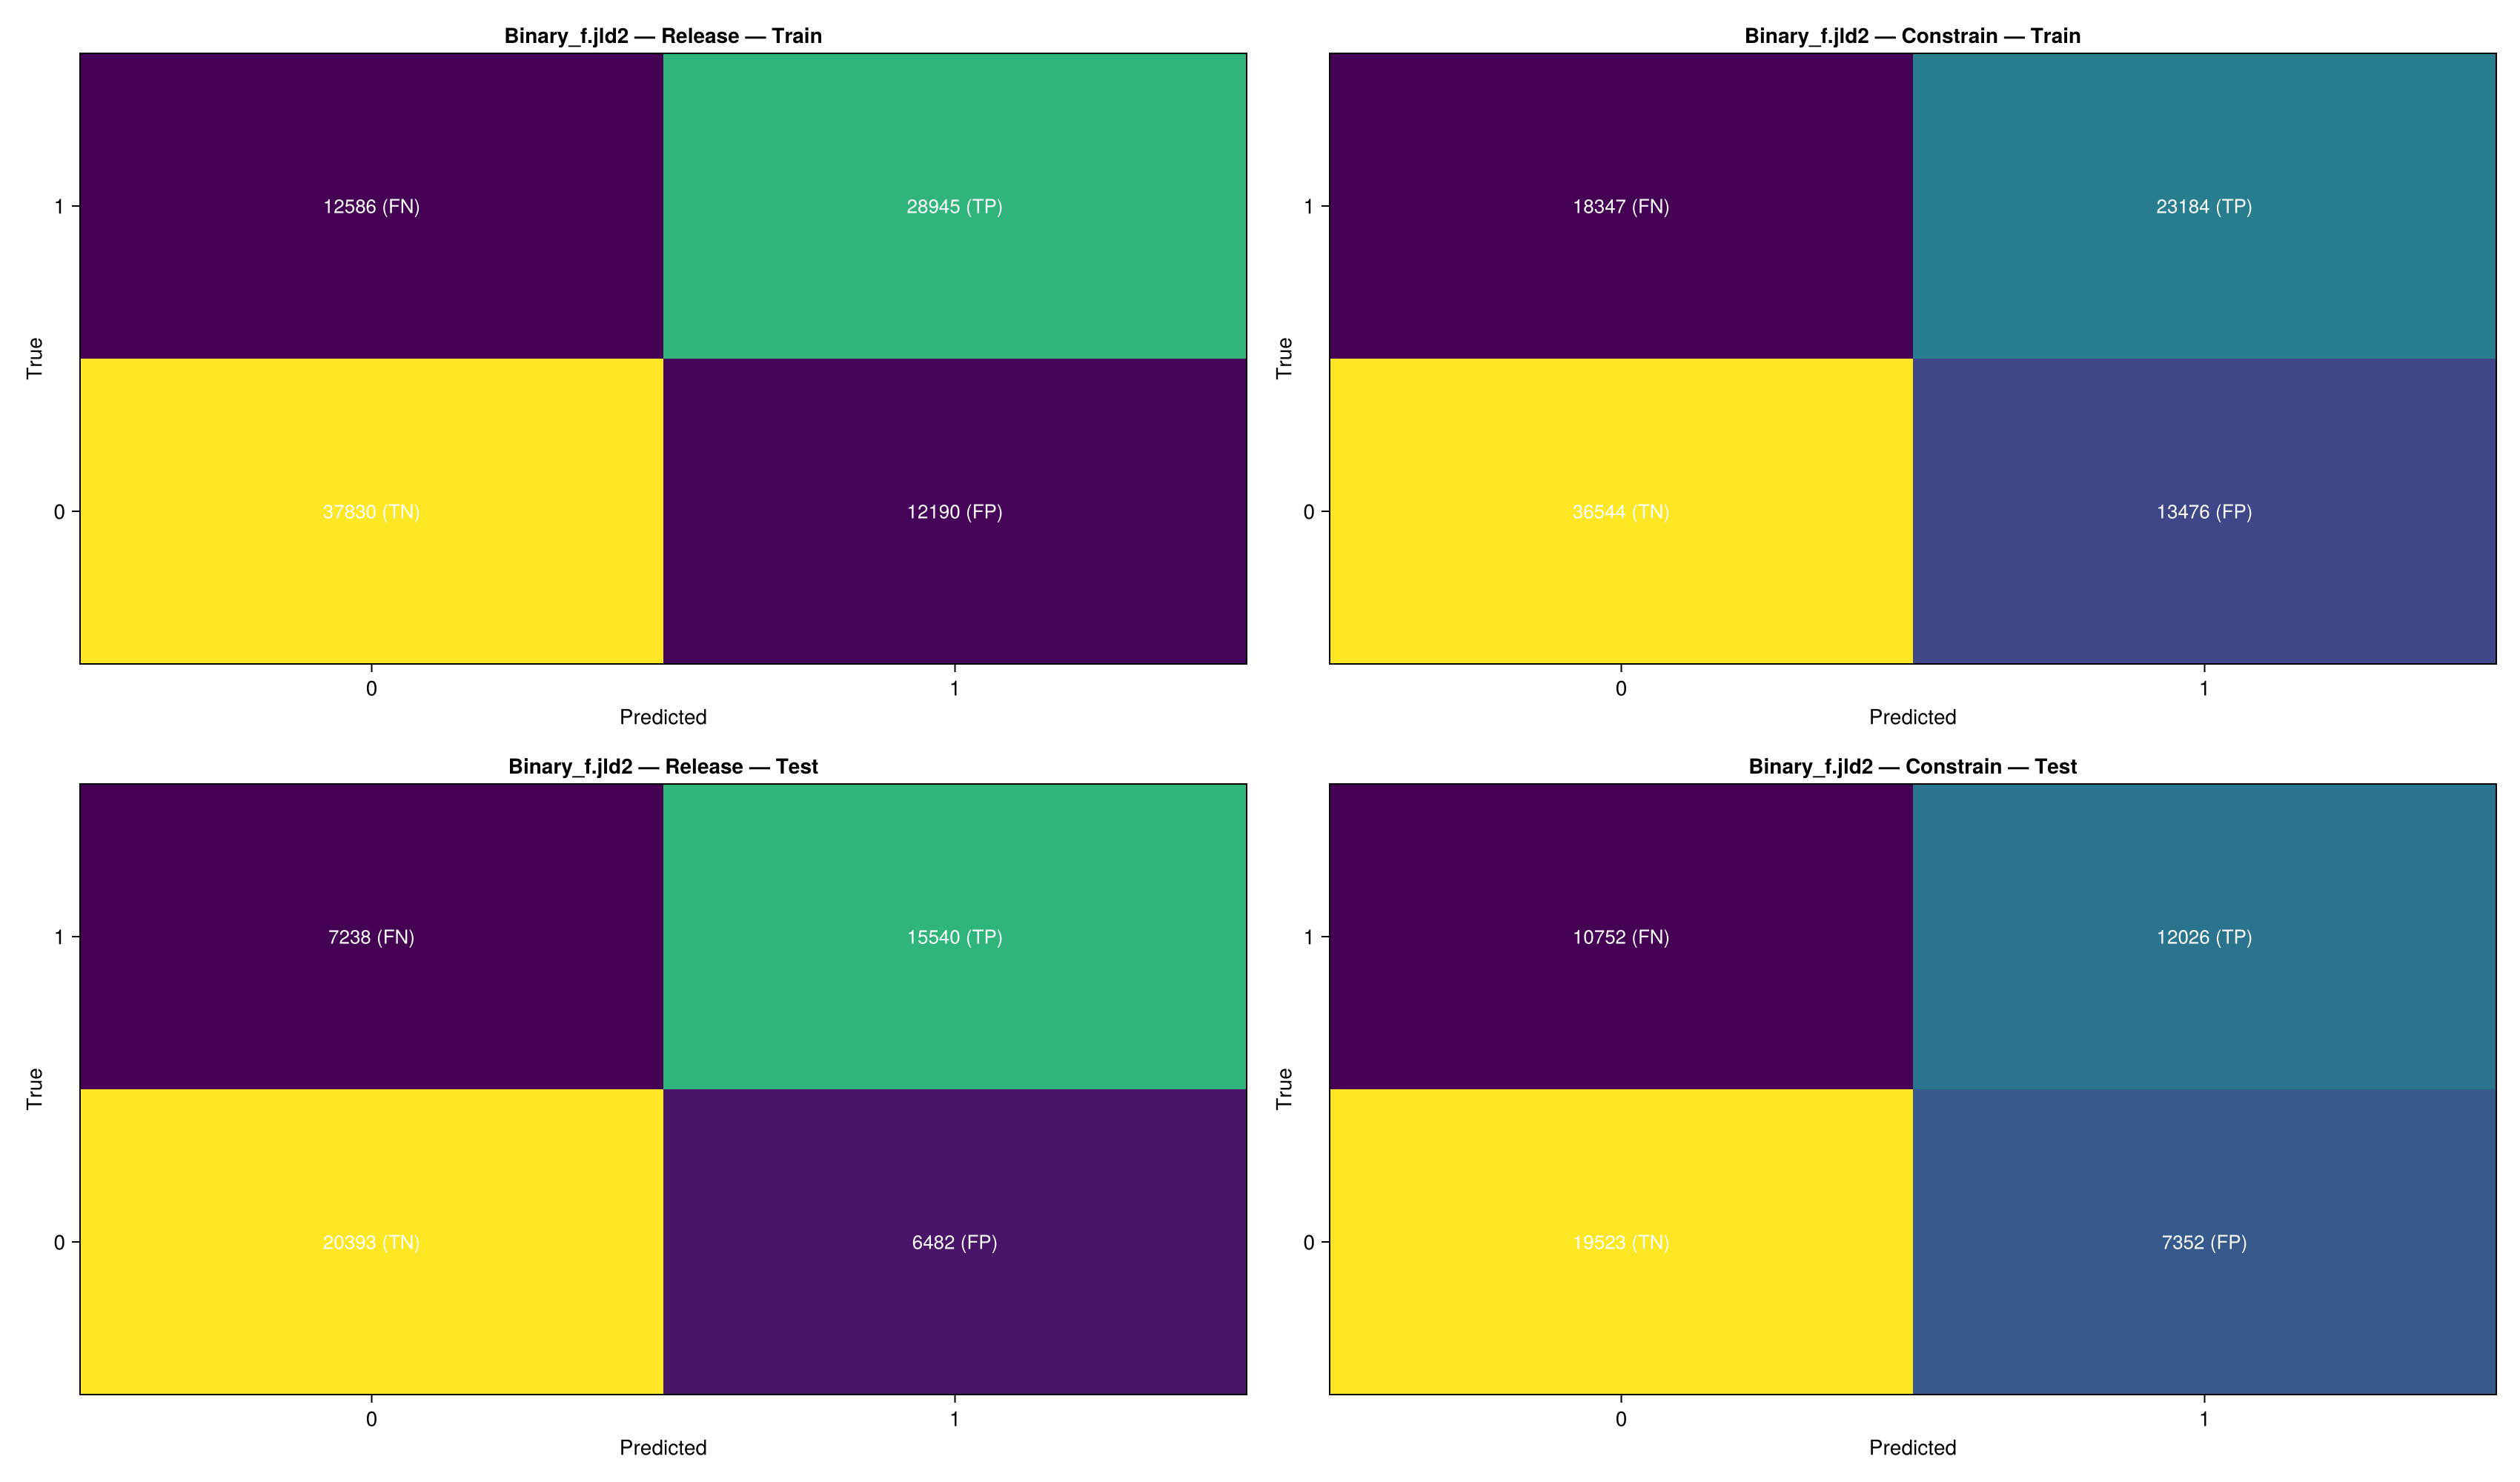

In [ ]:
show_rbm_results(results, 1)

In [ ]:
# ----------------------------
# Test on whole dataset
# ----------------------------
ŝ = vec(sum(X .* (Ŵ_second * X), dims=1))
p̂ = σ.(ŝ)

acc = mean((p̂ .>= 0.5f0) .== (y .== 1f0))
logloss  = mean(-y .* log.(p̂ .+ 1f-6) .-
                (1f0 .- y) .* log.(1f0 .- p̂ .+ 1f-6))

println("Accuracy (whole dataset): ", acc)
println("Log-loss (whole dataset): ", logloss)
y_true = y .== 1f0
y_pred = p̂ .>= mean(y)

TP = sum(y_pred .&  y_true)
TN = sum(.!y_pred .& .!y_true)
FP = sum(y_pred .& .!y_true)
FN = sum(.!y_pred .&  y_true)

println("Confusion matrix (rows = true, cols = predicted)")
println("          Pred 0   Pred 1")
println("True 0    ", TN, "        ", FP)
println("True 1    ", FN, "        ", TP)


Accuracy (whole dataset): 0.8932761785274506
Log-loss (whole dataset): 0.3018772759065856
Confusion matrix (rows = true, cols = predicted)
          Pred 0   Pred 1
True 0    76895        0
True 1    9187        0


In [ ]:
Ŵ_second_full, res_second_full = fit_quadratic_logistic(onehot, label)
# ----------------------------
# Test on whole dataset
# ----------------------------
ŝ = vec(sum(X .* (Ŵ_second_full * X), dims=1))
p̂ = σ.(ŝ)

accuracy = mean((p̂ .>= 0.5f0) .== (y .== 1f0))
logloss  = mean(-y .* log.(p̂ .+ 1f-6) .-
                (1f0 .- y) .* log.(1f0 .- p̂ .+ 1f-6))

println("Accuracy (whole dataset): ", accuracy)
println("Log-loss (whole dataset): ", logloss)
println("Converged: ", Optim.converged(res_second_full))
println("Final objective: ", Optim.minimum(res_second_full))

In [ ]:
const EXPECTED_SEQUENCE_LENGTH = 81

function read_protein_sequences(filepath::String)::Dict{String, String}
    sequences = Dict{String, String}()

    try
        open(filepath, "r") do file
            for (line_number, line) in enumerate(eachline(file))
                trimmed_line = strip(line)
                if isempty(trimmed_line)
                    continue
                end

                # Extract the last 81 characters as the sequence
                sequence = last(trimmed_line, EXPECTED_SEQUENCE_LENGTH)

                # Everything before the sequence is the name + metadata
                name = strip(first(trimmed_line, length(trimmed_line) - EXPECTED_SEQUENCE_LENGTH))

                sequences[name] = sequence
            end
        end
        return sequences

    catch e
        @error "An error occurred while reading the file: $e"
        return Dict{String, String}()
    end
end

protein_data = read_protein_sequences("PDZ_out.txt")
sequence_names = collect(keys(protein_data))
sequences_vector = collect(values(protein_data))
PDZ_tensor = one_hot_encode(sequences_vector, alphabet, alphabet_dict)
println(size(PDZ_tensor))

(21, 81, 84)


In [ ]:
cluster_1 = ["HtrA3", "ZO-1 1"]
cluster_2 = ["Gm1582", "Lin7c", "SAP102 3", "SAP97 3", "Scrb1 3", "β1-syntrophin"]
cluster_3 = ["Magi-1 6", "Magi-2 6", "Magi-3 5", "PSD95 1", "SAP97 1"]
cluster_4 = ["NHERF-1 1", "Pdzk1 1", "Pdzk1 3", "Shank1", "Shank3"]

function find_indices(ref::Vector{String}, data::Vector{String})
    result = Dict{String, Vector{Int}}()
    for r in ref
        result[r] = findall(x -> x == r, data)
    end
    return result
end
idx_1 = find_indices(cluster_1, sequence_names)
idx_2 = find_indices(cluster_2, sequence_names)
idx_3 = find_indices(cluster_3, sequence_names)
idx_4 = find_indices(cluster_4, sequence_names)

v1 = sort(unique(vcat(values(idx_1)...)))
v2 = sort(unique(vcat(values(idx_2)...)))
v3 = sort(unique(vcat(values(idx_3)...)))
v4 = sort(unique(vcat(values(idx_4)...)))

index_groups = Dict(
    "Cluster 1" => v1,
    "Cluster 2" => v2,
    "Cluster 3" => v3,
    "Cluster 4" => v4
)



Dict{String, Vector{Int64}} with 4 entries:
  "Cluster 2" => [10, 16, 20, 47, 68, 81]
  "Cluster 1" => [30, 64]
  "Cluster 3" => [35, 48, 51, 65, 76]
  "Cluster 4" => [6, 22, 25, 26, 33]

📁 Found 4 RBMs in /home/jacopo/PDZ/rbms_fs
⚙️ Processing Binary_fs_10.jld2
📊 Average distance (ALL sequences): 26.6
  🔸 Avg distance in Cluster 2 normalized by average distance: 0.39 (n=6)
  🔸 Avg distance in Cluster 1 normalized by average distance: 1.74 (n=2)
  🔸 Avg distance in Cluster 3 normalized by average distance: 0.2 (n=5)
  🔸 Avg distance in Cluster 4 normalized by average distance: 0.86 (n=5)
Variance explained by PC1: 66.85%
Variance explained by PC2: 33.15%


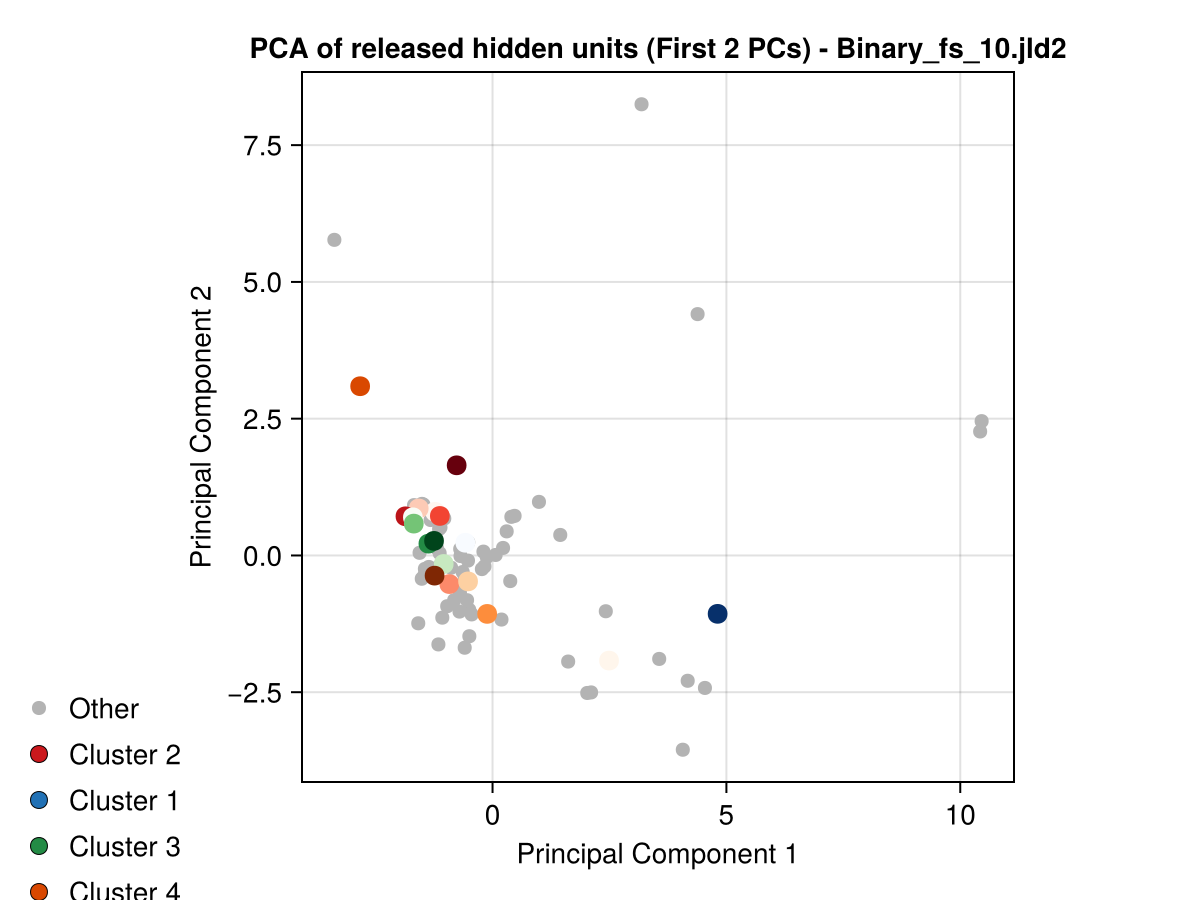

⚙️ Processing Binary_fs_15.jld2
📊 Average distance (ALL sequences): 25.94
  🔸 Avg distance in Cluster 2 normalized by average distance: 0.38 (n=6)
  🔸 Avg distance in Cluster 1 normalized by average distance: 1.46 (n=2)
  🔸 Avg distance in Cluster 3 normalized by average distance: 0.27 (n=5)
  🔸 Avg distance in Cluster 4 normalized by average distance: 0.82 (n=5)
Variance explained by PC1: 67.97%
Variance explained by PC2: 32.03%


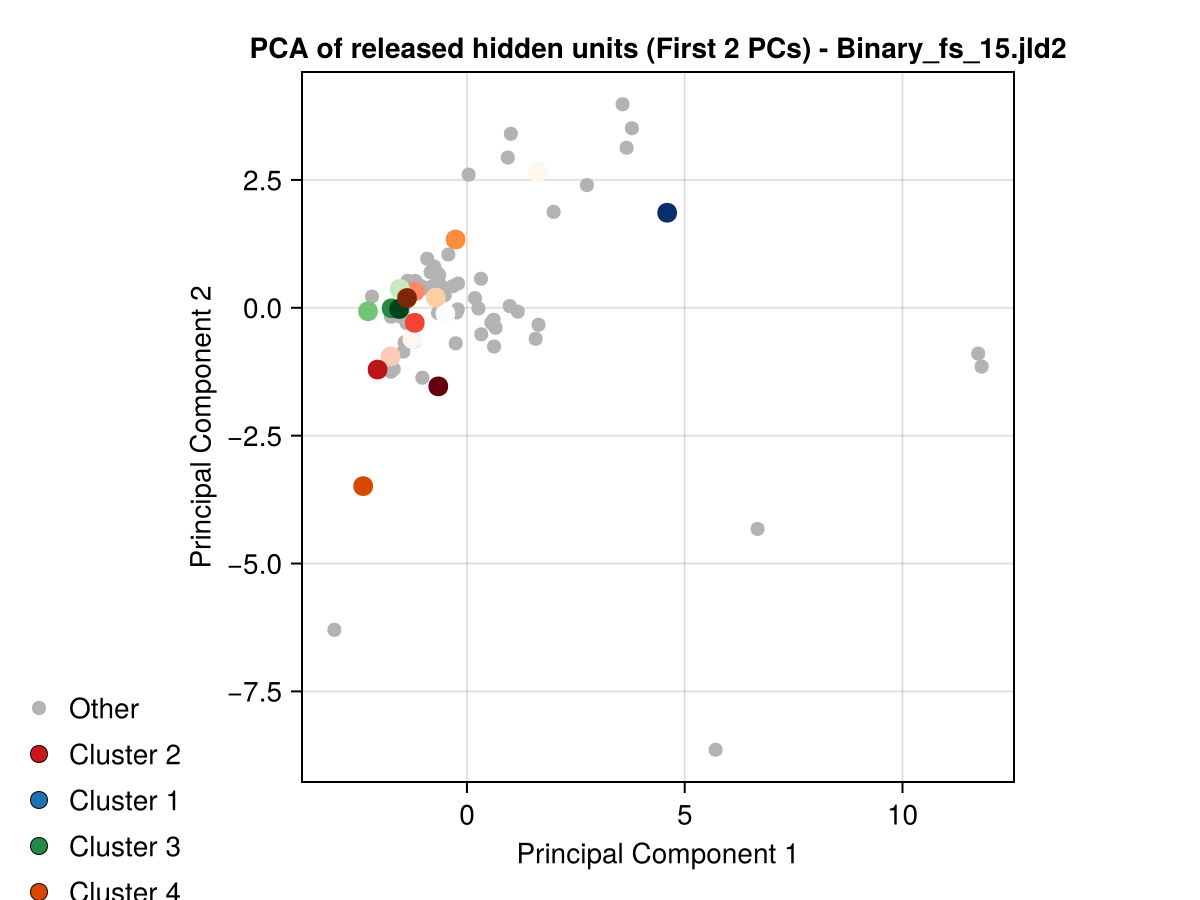

⚙️ Processing Binary_fs_20.jld2
📊 Average distance (ALL sequences): 28.32
  🔸 Avg distance in Cluster 2 normalized by average distance: 0.46 (n=6)
  🔸 Avg distance in Cluster 1 normalized by average distance: 1.38 (n=2)
  🔸 Avg distance in Cluster 3 normalized by average distance: 0.32 (n=5)
  🔸 Avg distance in Cluster 4 normalized by average distance: 0.77 (n=5)
Variance explained by PC1: 70.6%
Variance explained by PC2: 29.4%


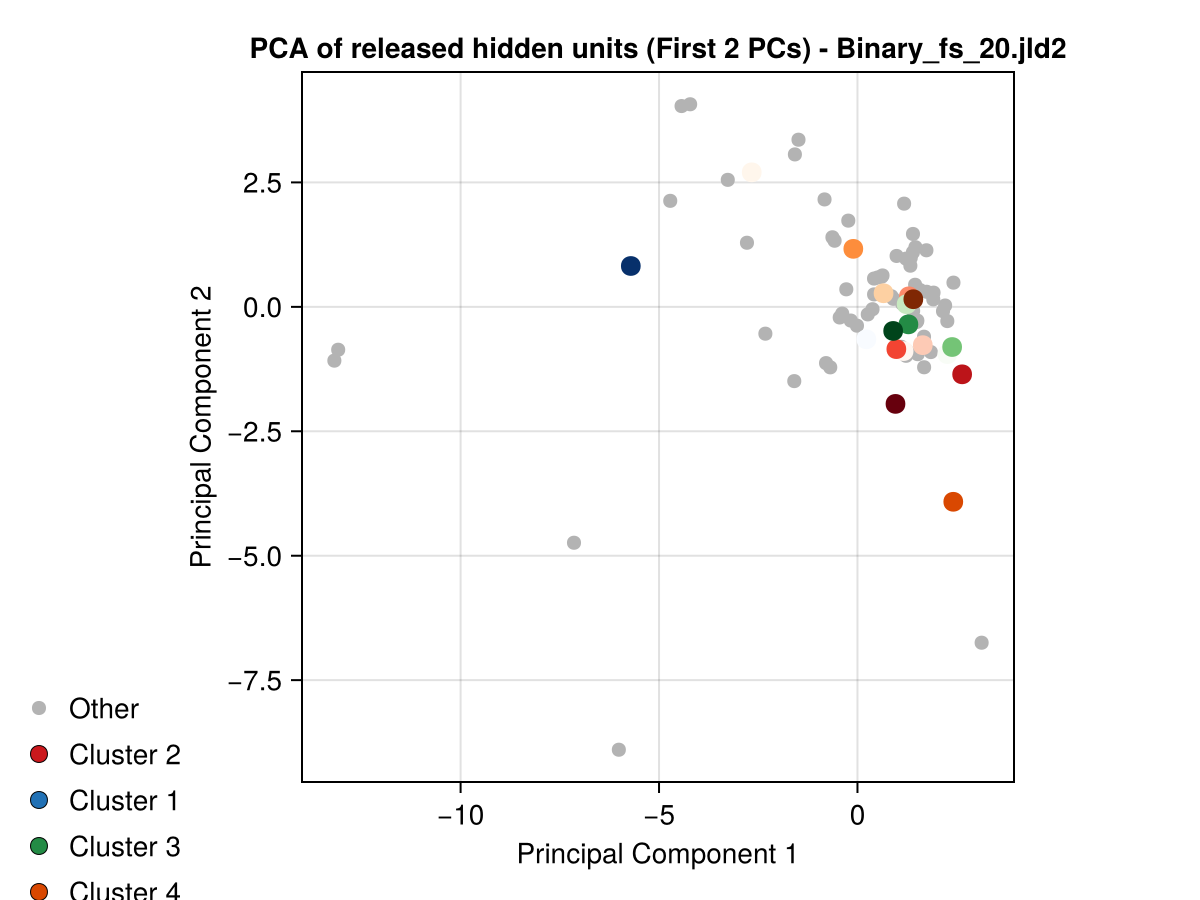

⚙️ Processing Binary_fs_5.jld2
📊 Average distance (ALL sequences): 24.8
  🔸 Avg distance in Cluster 2 normalized by average distance: 0.42 (n=6)
  🔸 Avg distance in Cluster 1 normalized by average distance: 2.07 (n=2)
  🔸 Avg distance in Cluster 3 normalized by average distance: 0.25 (n=5)
  🔸 Avg distance in Cluster 4 normalized by average distance: 0.96 (n=5)
Variance explained by PC1: 74.87%
Variance explained by PC2: 25.13%


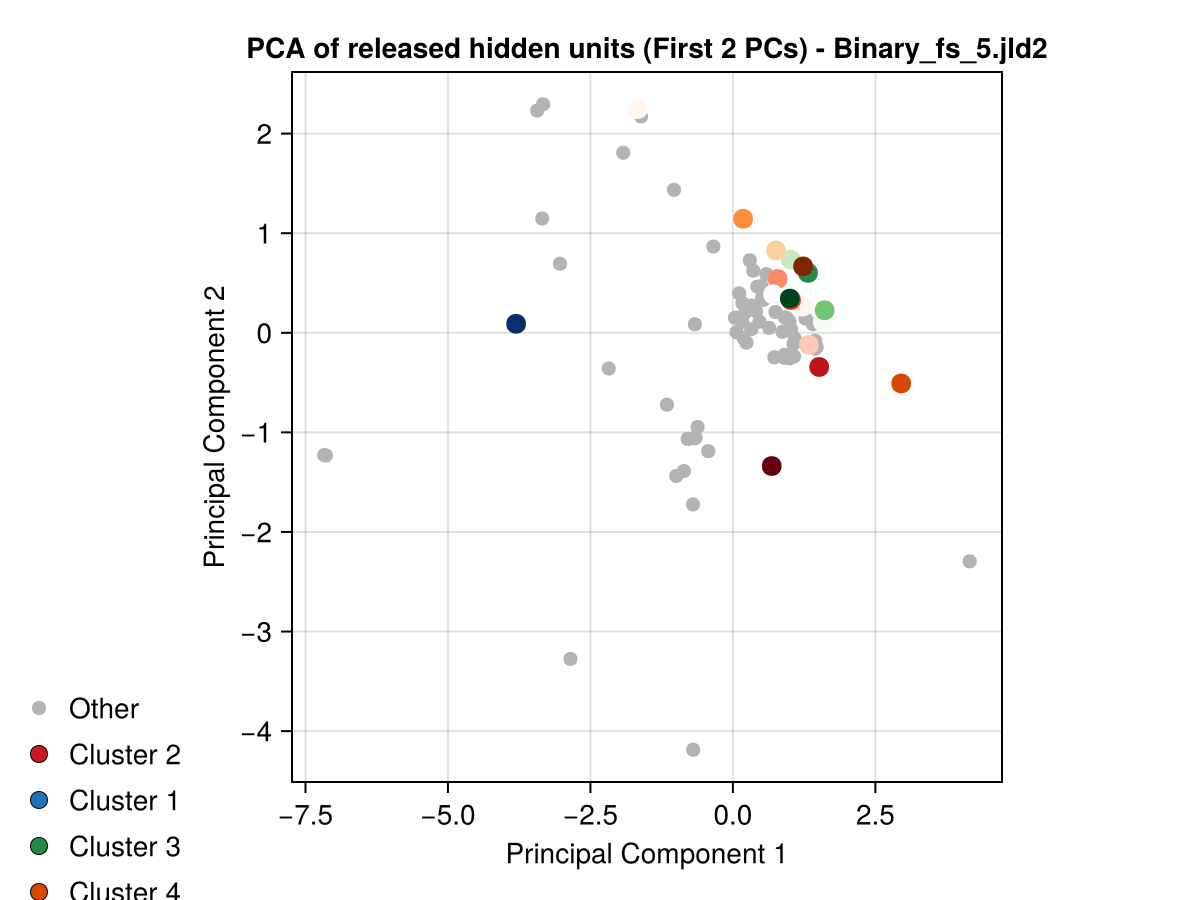

NamedTuple[]

In [ ]:
using InteractiveUtils
using MultivariateStats 
using Distances

function get_split_index(file::String)
    fname = strip(basename(file))
    if haskey(split_lookup, fname)
        return split_lookup[fname]
    else
        error("❌ No split index defined for RBM file: $fname.\nAdd it to split_lookup.")
    end
end


function PCA_hidden_rbms(
    rbm_dir::String,
    data::Array{<:Real,3},
    sequence_names::Vector{String},
    index_groups::Dict{String, Vector{Int}} = Dict()
)

    # Find all .jld2 RBMs in folder
    rbm_files = sort(filter(f->endswith(f, ".jld2"), readdir(rbm_dir)))
    println("📁 Found $(length(rbm_files)) RBMs in $rbm_dir")
    results = NamedTuple[]

    for file in rbm_files
        println("⚙️ Processing $file")
        rbm_path    = joinpath(rbm_dir, file)
        split_index = get_split_index(file)

        try
            rbm = load_object(rbm_path)
            h  = inputs_h_from_v(rbm, data)  # (hidden_units × N)

            h1 = h[1:split_index, :]
            d = h1  # Now X[i, :] is hidden activation vector of sequence i
            c = size(d, 2)
            all_dists = pairwise(Euclidean(), d)
            avg_all = sum(all_dists) / (c^2 - c)   # exclude self-distances
            println("📊 Average distance (ALL sequences): ", round(avg_all, digits=2))
            for (group_name, idxs) in index_groups
                isempty(idxs) && continue
                valid = filter(i -> 1 ≤ i ≤ c, idxs)
            if length(valid) >= 2
                subX = d[:, valid]
                sub_d = pairwise(Euclidean(), subX)
                avg = sum(sub_d) / (length(valid)^2 - length(valid))
                println("  🔸 Avg distance in $group_name normalized by average distance: ",
                 round(avg/avg_all, digits=2),
                    " (n=", length(valid), ")")
            else
                println("  🔸 $group_name has <2 sequences → skip")
            end
        end
            X_mean = mean(h1, dims=2)
            X_std = std(h1, dims=2)
            X_standardized = (h1 .- X_mean) ./ X_std
            M= MultivariateStats.fit(PCA, X_standardized; maxoutdim=2)
            Y = MultivariateStats.transform(M, X_standardized)

            # Print the variance explained by each principal component (PC)
            principal_vars = principalvars(M)
            total_variance = sum(principal_vars)
            explained_ratio = principal_vars ./ total_variance

            println("Variance explained by PC1: ", round(explained_ratio[1]*100, digits=2), "%")
            println("Variance explained by PC2: ", round(explained_ratio[2]*100, digits=2), "%")
            # Extract the components
            PC1 = Y[1, :]
            PC2 = Y[2, :]
            N = length(PC1) 
            sequence_indices = 1:N 

            fig = Figure()
            ax = Axis(
            fig[1, 1],  
            xlabel = "Principal Component 1",
            ylabel = "Principal Component 2",
            title = "PCA of released hidden units (First 2 PCs) - $file",
            aspect = 1
            )
            legend_elements = MarkerElement[]
            legend_labels = String[]

# Plot ALL points dimmed
            bg = scatter!(ax, PC1, PC2;
                markersize = 10,
                color       = :gray70,
                strokecolor = :black,
            )

            push!(legend_elements,
                MarkerElement(color = :gray70, marker = :circle, markersize = 10)
            )
            push!(legend_labels, "Other")

            colormaps = [cgrad(:Reds), cgrad(:Blues), cgrad(:Greens), cgrad(:Oranges)]
            cmap_count = length(colormaps)

            gidx = 1
            for (group_name, idxs) in index_groups
                sorted_idxs = sort(idxs)
                colors = colormaps[gidx][LinRange(0,1,length(sorted_idxs))]

                scatter!(
                    ax,
                    PC1[sorted_idxs],
                    PC2[sorted_idxs];
                    markersize = 14,
                    color = colors
                )

                representative_color = colormaps[gidx][end-2]

                push!(legend_elements,
                MarkerElement(
                        color = representative_color,
                        marker = :circle,
                        markersize = 12,
                        strokewidth = 0.5,
                        strokecolor = :black
                    )
                )
                push!(legend_labels, group_name)

                gidx = gidx < cmap_count ? gidx + 1 : 1
            end

            Legend(
                fig,                          # attach to axis instead of new grid cell
                legend_elements,
                legend_labels;
                position = :rb,              # right-bottom inside the plot
                framevisible = false
                )
            display(fig)
        catch e
            @warn "Failed: $file — $e"
        end
    end

    return results
end

results = PCA_hidden_rbms(
    "/home/jacopo/PDZ/rbms_fs",
    PDZ_tensor, 
    sequence_names,
    index_groups 
)

In [ ]:
basis = hcat(V[1,:], V[2,:])
PDZ_sequences = reshape(PDZ_tensor, 1701, size(PDZ_tensor, 3))
Y = basis' * PDZ_sequences
PC1 = Y[1, :]
PC2 = Y[2, :]

fig = Figure()
ax = Axis(
fig[1, 1],  
xlabel = "Direction 1",
ylabel = "Direction 2",
title = "Projection of PDZ sequences onto first 2 SVD modes",
aspect = 1
)
scatter!(
ax,
PC1,
PC2
)
display(fig)

ANALISI CONSTRAINT INTERACTION

In [ ]:
function plot_confusion_matrix(
    values::AbstractVector{<:Integer},
    title::String;
    filename::String = "confusion_matrix.png"
)
    @assert length(values) == 4 "values must be [tn, tp, fn, fp]"

    tn, tp, fn, fp = values
    total = tn + tp + fn + fp

    # Labels
    labels = ["Negative (0)", "Positive (1)"]

    # Base plot
    p = plot(
        xlim=(0.5, 2.5), ylim=(0.5, 2.5),
        xticks=(1:2, labels), yticks=(1:2, labels),
        xlabel="Predicted", ylabel="Actual",
        title="$title (n=$total)",
        aspect_ratio=:equal,
        legend=false,
        grid=false,
        framestyle=:box,
        background_color=:white,
        margin=10mm
    )

    # Colors (pastel & readable)
    c_correct = RGB(0.9, 1.0, 0.9)  # light green
    c_error   = RGB(1.0, 0.9, 0.9)  # light red

    # Background squares
    # TN (1,1)
    plot!(p, [0.5, 1.5, 1.5, 0.5], [0.5, 0.5, 1.5, 1.5],
          seriestype=:shape, fillcolor=c_correct, linecolor=:grey)

    # FP (2,1)
    plot!(p, [1.5, 2.5, 2.5, 1.5], [0.5, 0.5, 1.5, 1.5],
          seriestype=:shape, fillcolor=c_error, linecolor=:grey)

    # FN (1,2)
    plot!(p, [0.5, 1.5, 1.5, 0.5], [1.5, 1.5, 2.5, 2.5],
          seriestype=:shape, fillcolor=c_error, linecolor=:grey)

    # TP (2,2)
    plot!(p, [1.5, 2.5, 2.5, 1.5], [1.5, 1.5, 2.5, 2.5],
          seriestype=:shape, fillcolor=c_correct, linecolor=:grey)

    # Centered annotations
    style = (12, :black, :center)
    annotate!(p, 1, 1, text("TN\n$tn", style...))
    annotate!(p, 2, 1, text("FP\n$fp", style...))
    annotate!(p, 1, 2, text("FN\n$fn", style...))
    annotate!(p, 2, 2, text("TP\n$tp", style...))

    # Save
    mkpath(dirname(filename))
    savefig(p, filename)
    println("Confusion matrix saved to: $filename")

    return p
end

plot_confusion_matrix (generic function with 1 method)

Confusion matrix saved to: plots/cm_sequences_train_fulldataset.png
Confusion matrix saved to: plots/cm_sequences_train.png
Confusion matrix saved to: plots/cm_sequences_test.png


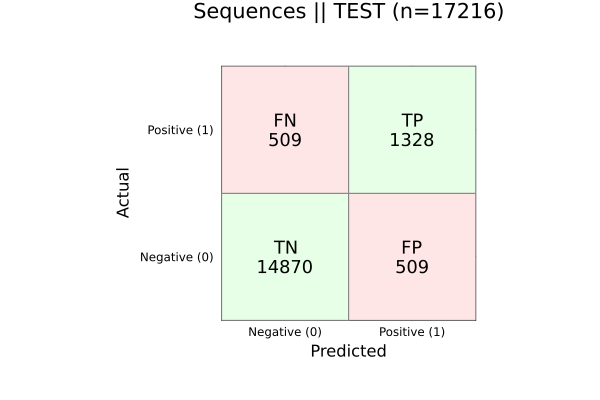

In [4]:
using Measures
using Plots
plot_confusion_matrix(
    [74346, 6640, 2547, 2549],
    "Sequences || TRAIN Entire dataset";
    filename="plots/cm_sequences_train_fulldataset.png"
)


plot_confusion_matrix(
    [59480, 5314, 2036, 2036],
    "Sequences || TRAIN";
    filename="plots/cm_sequences_train.png"
)

plot_confusion_matrix(
    [14870, 1328, 509, 509],
    "Sequences || TEST";
    filename="plots/cm_sequences_test.png"
)

Confusion matrix saved to: plots/cm_rbm_Binary_fs_10_release_train.png
Confusion matrix saved to: plots/cm_rbm_Binary_fs_10_release_test.png
Confusion matrix saved to: plots/cm_rbm_Binary_fs_10_constrain_train.png
Confusion matrix saved to: plots/cm_rbm_Binary_fs_10_constrain_test.png
Confusion matrix saved to: plots/cm_rbm_Binary_fs_15_release_train.png
Confusion matrix saved to: plots/cm_rbm_Binary_fs_15_release_test.png
Confusion matrix saved to: plots/cm_rbm_Binary_fs_15_constrain_train.png
Confusion matrix saved to: plots/cm_rbm_Binary_fs_15_constrain_test.png
Confusion matrix saved to: plots/cm_rbm_Binary_fs_20_release_train.png
Confusion matrix saved to: plots/cm_rbm_Binary_fs_20_release_test.png
Confusion matrix saved to: plots/cm_rbm_Binary_fs_20_constrain_train.png
Confusion matrix saved to: plots/cm_rbm_Binary_fs_20_constrain_test.png
Confusion matrix saved to: plots/cm_rbm_Binary_fs_5_release_train.png
Confusion matrix saved to: plots/cm_rbm_Binary_fs_5_release_test.png
Con

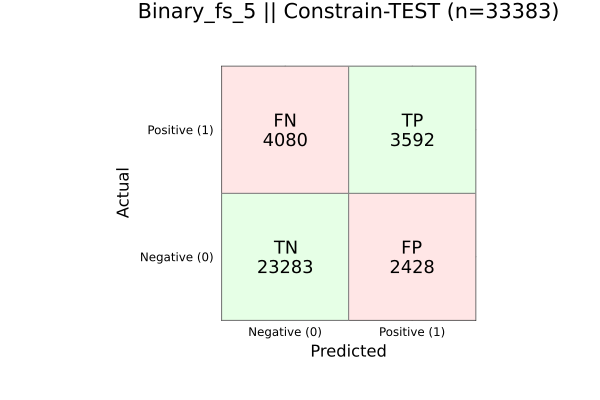

In [5]:
using Measures
using Plots
# =====================
# Binary_fs_10
# =====================

plot_confusion_matrix(
    [44834, 5186, 5186, 6680],
    "Binary_fs_10 || Release-TRAIN";
    filename="plots/cm_rbm_Binary_fs_10_release_train.png"
)

plot_confusion_matrix(
    [24028, 2847, 3040, 3468],
    "Binary_fs_10 || Release-TEST";
    filename="plots/cm_rbm_Binary_fs_10_release_test.png"
)

plot_confusion_matrix(
    [43674, 6346, 6346, 5520],
    "Binary_fs_10 || Constrain-TRAIN";
    filename="plots/cm_rbm_Binary_fs_10_constrain_train.png"
)

plot_confusion_matrix(
    [23229, 3646, 3980, 2528],
    "Binary_fs_10 || Constrain-TEST";
    filename="plots/cm_rbm_Binary_fs_10_constrain_test.png"
)

# =====================
# Binary_fs_15
# =====================

plot_confusion_matrix(
    [45279, 4741, 4740, 7126],
    "Binary_fs_15 || Release-TRAIN";
    filename="plots/cm_rbm_Binary_fs_15_release_train.png"
)

plot_confusion_matrix(
    [24120, 2755, 2818, 3690],
    "Binary_fs_15 || Release-TEST";
    filename="plots/cm_rbm_Binary_fs_15_release_test.png"
)

plot_confusion_matrix(
    [43645, 6375, 6374, 5492],
    "Binary_fs_15 || Constrain-TRAIN";
    filename="plots/cm_rbm_Binary_fs_15_constrain_train.png"
)

plot_confusion_matrix(
    [23241, 3634, 3926, 2582],
    "Binary_fs_15 || Constrain-TEST";
    filename="plots/cm_rbm_Binary_fs_15_constrain_test.png"
)

# =====================
# Binary_fs_20
# =====================

plot_confusion_matrix(
    [45510, 4510, 4510, 7356],
    "Binary_fs_20 || Release-TRAIN";
    filename="plots/cm_rbm_Binary_fs_20_release_train.png"
)

plot_confusion_matrix(
    [24310, 2565, 2772, 3736],
    "Binary_fs_20 || Release-TEST";
    filename="plots/cm_rbm_Binary_fs_20_release_test.png"
)

plot_confusion_matrix(
    [43526, 6494, 6494, 5372],
    "Binary_fs_20 || Constrain-TRAIN";
    filename="plots/cm_rbm_Binary_fs_20_constrain_train.png"
)

plot_confusion_matrix(
    [23229, 3646, 4076, 2432],
    "Binary_fs_20 || Constrain-TEST";
    filename="plots/cm_rbm_Binary_fs_20_constrain_test.png"
)

# =====================
# Binary_fs_5
# =====================

plot_confusion_matrix(
    [44646, 5374, 5374, 6492],
    "Binary_fs_5 || Release-TRAIN";
    filename="plots/cm_rbm_Binary_fs_5_release_train.png"
)

plot_confusion_matrix(
    [23910, 2965, 3084, 3424],
    "Binary_fs_5 || Release-TEST";
    filename="plots/cm_rbm_Binary_fs_5_release_test.png"
)

plot_confusion_matrix(
    [43714, 6306, 6306, 5560],
    "Binary_fs_5 || Constrain-TRAIN";
    filename="plots/cm_rbm_Binary_fs_5_constrain_train.png"
)

plot_confusion_matrix(
    [23283, 3592, 4080, 2428],
    "Binary_fs_5 || Constrain-TEST";
    filename="plots/cm_rbm_Binary_fs_5_constrain_test.png"
)


In [ ]:
function Q_inter(
    filtered_tensor::AbstractArray{T,3},
    split_idx::Int,
    labels::AbstractVector{<:Real}
    ) where {T<:Real}

    a, n_amino, n_exp = size(filtered_tensor)
    @assert 1 ≤ split_idx < n_amino
    @assert length(labels) == n_exp

    U = reshape(filtered_tensor[:, 1:split_idx, :], a * split_idx, n_exp)
    V = reshape(filtered_tensor[:, split_idx+1:end, :],
                a * (n_amino - split_idx), n_exp)

    acc_y = zeros(Float32, size(U,1), size(V,1))
    acc_all = zeros(Float32, size(U,1), size(V,1))

    for i in 1:n_exp
        x = U[:, i]
        v = V[:, i]
        acc_all .+= x * v'
        acc_y   .+= labels[i] .* (x * v')
    end

    acc_y   ./= n_exp
    acc_all ./= n_exp

    return acc_y .- acc_all
end

pdz_pep_data = JLD2.load("pdz_pep_matrices_fast.jld2")
filename_1 = "output.txt"
Gogl_seq, classes = filter_lookup_concat("PDZ_2022.xlsx", "PDZ_2022_final.xlsx", 4)


receptor_str, ligand_str, bind_vec = read_binding_file(filename_1)
label_Stiffler = receptor_str .* ligand_str
split_idx = 81

Stiffler_onehot = one_hot_encode(label_Stiffler, alphabet, alphabet_dict)
Gogl_onehot = one_hot_encode(Gogl_seq, alphabet, alphabet_dict)

sequence_PDZ = one_hot_encode(receptor_str, alphabet, alphabet_dict)


label = cat(classes, bind_vec, dims=1)
onehot = cat(Gogl_onehot, Stiffler_onehot, dims=3)
labeled_reshape = reshape(onehot, :, size(onehot, 3))
U_matrix = pdz_pep_data["U_general"]  # PDZ embedding matrix
V_matrix = pdz_pep_data["V_general"]  # Peptide embedding matrix

Q_interaction = Q_inter(onehot, split_idx, label)





Skipped rows: 2037


1701×210 Matrix{Float32}:
  0.0           0.0           0.0          …   0.0           0.0
  0.0           0.0           0.0              0.0           0.0
  0.0           0.0           0.0              0.0           0.0
 -0.000824795  -0.000151019  -0.00119653       0.0          -0.000185869
  0.0           0.0           0.0              0.0           0.0
  0.0           0.0           0.0          …   0.0           0.0
  0.0           0.0           0.0              0.0           0.0
  0.0           0.0           0.0              0.0           0.0
  0.0           0.0           0.0              0.0           0.0
  0.0           0.0           0.0              0.0           0.0
  0.0           0.0           0.0          …   0.0           0.0
  0.0           0.0           0.0              0.0           0.0
  0.0           0.0           0.0              0.0           0.0
  ⋮                                        ⋱                
 -0.0010339    -0.000197486  -0.00135917      -3.48505f-5   

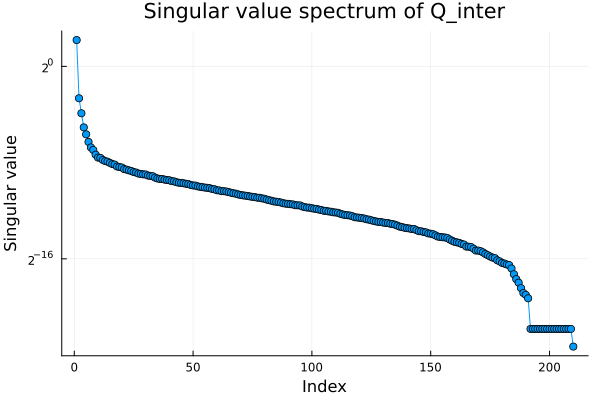

In [ ]:
    # --- SVD ---
F = svd(Q_interaction)

S = F.S

    # --- plot ---
plot(
    S,
    yscale = :identity,
    marker = :circle,
    xlabel = "Index",
    ylabel = "Singular value",
    title = "Singular value spectrum of Q_inter",
    legend = false
)
plot(
    S,
    yscale = :log2,
    marker = :circle,
    xlabel = "Index",
    ylabel = "Singular value",
    title = "Singular value spectrum of Q_inter",
    legend = false
)


In [ ]:
using SequenceLogos
Q = Q_inter(filtered_tensor, split_idx, labels)
F = svd(Q)

U = F.U        # left singular vectors
S = F.S
"""
    svector_to_logomatrix(vec, a, L)

Convert singular vector → (alphabet × position) weight matrix
suitable for SequenceLogo.jl
"""
function svector_to_logomatrix(vec::AbstractVector, a::Int, L::Int)
    @assert length(vec) == a * L

    W = reshape(vec, a, L)

    # center and normalize per position
    W .-= mean(W, dims=1)
    W ./= sum(abs.(W), dims=1)

    return W
end
alphabet = collect("ACDEFGHIKLMNPQRSTVWY-")

a = 21
L = split_idx

for k in 1:5
    W = svector_to_logomatrix(U[:, k], a, L)

    logo = SequenceLogo.logo(
        W;
        alphabet = alphabet,
        title = "Singular vector $k  (σ = $(round(S[k], sigdigits=3)))",
        stack_order = :height,
        color_scheme = :chemistry
    )

    display(logo)
end

[ Info: Precompiling SequenceLogos [7a3f67ce-6eeb-4904-9da4-2cbd106a5944] (cache misses: wrong dep version loaded (2))


LoadError: UndefVarError: `Q_inter` not defined in `Main`
Suggestion: check for spelling errors or missing imports.